### Task 2: Robustness against adversarial attacks

In [42]:
import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import os
from sklearn.base import clone
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')
import copy
import traceback

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss

In [2]:
def load_mat_data(file_path, data_key):
    """
    Load data from a .mat file and extract the specific key.
    
    Parameters:
    -----------
    file_path : str
        Path to the MAT file
    data_key : str
        Key to extract from the MAT file
        
    Returns:
    --------
    numpy.ndarray
        Extracted data
    """
    data = scipy.io.loadmat(file_path)
    return data[data_key][0][0]

def load_iaprtc_dataset(data_dir="./IAPRTC/"):
    """
    Load the IAPRTC-12 dataset from MAT files.
    
    Parameters:
    -----------
    data_dir : str, default="./IAPRTC/"
        Directory containing the dataset files
        
    Returns:
    --------
    tuple
        (train_features, train_labels, test_features, test_labels)
    """
    # Define file paths
    train_features_path = f"{data_dir}IAPRTC-12_TrainFeat.mat"
    train_labels_path = f"{data_dir}IAPRTC-12_TrainLabels.mat"
    test_features_path = f"{data_dir}IAPRTC-12_TestFeat.mat"
    test_labels_path = f"{data_dir}IAPRTC-12_TestLabels.mat"
    
    # Load data
    train_features = load_mat_data(train_features_path, 'I_x_tr')
    train_labels = load_mat_data(train_labels_path, 'I_z_tr')
    test_features = load_mat_data(test_features_path, 'I_x_te')
    test_labels = load_mat_data(test_labels_path, 'I_z_te')
    
    return train_features, train_labels, test_features, test_labels

def print_dataset_info(train_features, train_labels, test_features, test_labels):
    """
    Print information about the dataset shapes.
    
    Parameters:
    -----------
    train_features : numpy.ndarray
        Training features
    train_labels : numpy.ndarray
        Training labels
    test_features : numpy.ndarray
        Test features
    test_labels : numpy.ndarray
        Test labels
    """
    print(f"Train Features: {train_features.shape}, Train Labels: {train_labels.shape}")
    print(f"Test Features: {test_features.shape}, Test Labels: {test_labels.shape}")

In [45]:
train_features, train_labels, test_features, test_labels = load_iaprtc_dataset()
print_dataset_info(train_features, train_labels, test_features, test_labels)

Train Features: (17665, 2048), Train Labels: (17665, 291)
Test Features: (1962, 2048), Test Labels: (1962, 291)


### Loading trained base Models

In [46]:
def load_preprocessors(paths):
    """
    Load data preprocessing models from saved files.
    
    Parameters:
    -----------
    paths : dict
        Dictionary containing paths to saved preprocessor models
        
    Returns:
    --------
    tuple
        (scaler, pca) - The loaded preprocessing models
    """
    scaler = joblib.load(paths['scaler'])
    pca = joblib.load(paths['pca'])
    return scaler, pca

def apply_transformations(features, scaler, pca):
    """
    Apply preprocessing transformations to features.
    
    Parameters:
    -----------
    features : array-like
        Features to transform
    scaler : object
        Fitted StandardScaler
    pca : object
        Fitted PCA model
        
    Returns:
    --------
    tuple
        (scaled_features, reduced_features)
    """
    scaled_features = scaler.transform(features)
    reduced_features = pca.transform(scaled_features)
    return scaled_features, reduced_features

def load_model(model_path, model_name):
    """
    Load a single model with error handling.
    
    Parameters:
    -----------
    model_path : str
        Path to the saved model file
    model_name : str
        Name of the model for display purposes
        
    Returns:
    --------
    object or None
        Loaded model if successful, None if an error occurs
    """
    try:
        model = joblib.load(model_path)
        print(f"Loaded {model_name} model")
        return model
    except Exception as e:
        print(f"Error loading {model_name} model: {e}")
        return None

def load_trained_models(model_configs):
    """
    Load all trained models based on configuration.
    
    Parameters:
    -----------
    model_configs : dict
        Dictionary mapping model names to their file paths
        
    Returns:
    --------
    dict
        Dictionary of successfully loaded models
    """
    trained_models = {}
    
    for model_name, model_path in model_configs.items():
        model = load_model(model_path, model_name)
        if model is not None:
            trained_models[model_name] = model
            
    return trained_models

In [47]:
class EnsembleModel:
    """
    Ensemble model that combines predictions from multiple models.
    """
    def __init__(self, models, model_names=None, weights=None):
        self.models = list(models.values())
        self.model_names = model_names or list(models.keys())
        
        # Equal weights by default
        if weights is None:
            self.weights = np.ones(len(self.models)) / len(self.models)
        else:
            self.weights = weights / np.sum(weights)
        
        # Track if each model uses reduced features
        self.uses_reduced = [name == 'Weighted KNN' for name in self.model_names]
    
    def predict(self, X):
        """
        Make predictions by averaging predictions from all models.
        """
        # Ensure X is 2D
        if X.ndim == 1:
            X = X.reshape(1, -1)
            
        # Store predictions from each model
        all_preds = []
        
        # Get predictions from each model
        for i, model in enumerate(self.models):
            if not self.uses_reduced[i]:
                pred = model.predict(X)
            else:
                # For models using reduced features, we skip
                continue
                
            all_preds.append(pred * self.weights[i])
        
        # Average predictions
        avg_pred = np.sum(all_preds, axis=0)
        
        # Convert to binary predictions (threshold at 0.5)
        binary_pred = (avg_pred > 0.5).astype(int)
        
        return binary_pred

In [48]:
preprocessor_paths = {
    'scaler': 'scaler.pkl',
    'pca': 'pca_model.pkl'
}

model_configs = {
    'Linear SVM': 'linear_svm.pkl',
    'Logistic Regression': 'logistic_regression.pkl',
    'Softmax Regression': 'softmax_regression.pkl',
    'Decision Tree': 'decision_tree.pkl',
    'Weighted KNN': 'weighted_knn.pkl'  
}

scaler, pca = load_preprocessors(preprocessor_paths)

X_test_scaled, X_test_reduced = apply_transformations(test_features, scaler, pca)

trained_base_models = load_trained_models(model_configs)

Loaded Linear SVM model
Loaded Logistic Regression model
Loaded Softmax Regression model
Loaded Decision Tree model
Loaded Weighted KNN model


### Base Model Evaluation

In [49]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate a multilabel classification model using various metrics.
    
    Parameters:
    -----------
    model : classifier object
        The trained model with a predict method
    X_test : array-like
        Test features
    y_test : array-like
        True test labels
    
    Returns:
    --------
    dict
        Dictionary containing evaluation metrics for multilabel classification
    """
    # Get model predictions
    y_pred = model.predict(X_test)
    
    # Define metrics to calculate with their parameters
    metrics = {
        'accuracy': (accuracy_score, {}),
        'precision_micro': (precision_score, {'average': 'micro'}),
        'precision_macro': (precision_score, {'average': 'macro'}),
        'recall_micro': (recall_score, {'average': 'micro'}),
        'recall_macro': (recall_score, {'average': 'macro'}),
        'f1_micro': (f1_score, {'average': 'micro'}),
        'f1_macro': (f1_score, {'average': 'macro'}),
        'hamming_loss': (hamming_loss, {})
    }
    
    # Calculate all metrics
    results = {}
    for metric_name, (metric_func, params) in metrics.items():
        results[metric_name] = metric_func(y_test, y_pred, **params)
    
    return results

In [50]:
def evaluate_all_models(trained_models, features, reduced_features, labels, prefix=""):
    """
    Evaluate all models and collect performance metrics.
    
    Parameters:
    -----------
    trained_models : dict
        Dictionary of trained models
    features : array-like
        Features to evaluate on
    labels : array-like
        True labels
    prefix : str, default=""
        Prefix for console output
        
    Returns:
    --------
    dict
        Dictionary containing evaluation metrics for each model
    """
    results = {}
    print(f"\nEvaluating {prefix}model performance...")
    
    for name, model in trained_models.items():
        print(f"Evaluating {name}...")
        if name != 'Weighted KNN':
            metrics = evaluate_model(model, features, labels)
        else:
            metrics = evaluate_model(model, reduced_features, labels)
        results[name] = metrics
        print(f"  Accuracy: {metrics['accuracy']:.4f}, F1 (micro): {metrics['f1_micro']:.4f}")
    
    return results

def create_metrics_dataframe(results):
    """
    Create a DataFrame from model evaluation results.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing model evaluation metrics
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing formatted metrics
    """
    metrics_df = pd.DataFrame({
        'Model': [],
        'Accuracy': [],
        'Precision (micro)': [],
        'Recall (micro)': [],
        'F1 (micro)': [],
        'Hamming Loss': []
    })
    
    for name, metrics in results.items():
        metrics_df = pd.concat([metrics_df, pd.DataFrame({
            'Model': [name],
            'Accuracy': [metrics['accuracy']],
            'Precision (micro)': [metrics['precision_micro']],
            'Recall (micro)': [metrics['recall_micro']],
            'F1 (micro)': [metrics['f1_micro']],
            'Hamming Loss': [metrics['hamming_loss']]
        })])
    
    return metrics_df

def display_and_save_results(metrics_df, title="Model performance", output_file=None):
    """
    Display results and optionally save to CSV.
    
    Parameters:
    -----------
    metrics_df : pd.DataFrame
        DataFrame containing metrics
    title : str, default="Model performance"
        Title for console output
    output_file : str, optional
        Path to save results CSV
    """
    print(f"\n{title}:")
    print(metrics_df.to_string(index=False))
    
    if output_file:
        metrics_df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")

In [51]:
base_results = evaluate_all_models(trained_base_models, X_test_scaled, X_test_reduced, test_labels, prefix="base ")
base_df = create_metrics_dataframe(base_results)
display_and_save_results(base_df, title="Base model performance", output_file="base_model_performance.csv")


Evaluating base model performance...
Evaluating Linear SVM...
  Accuracy: 0.0183, F1 (micro): 0.3475
Evaluating Logistic Regression...
  Accuracy: 0.0000, F1 (micro): 0.1302
Evaluating Softmax Regression...
  Accuracy: 0.0000, F1 (micro): 0.1302
Evaluating Decision Tree...
  Accuracy: 0.0102, F1 (micro): 0.3342
Evaluating Weighted KNN...
  Accuracy: 0.0347, F1 (micro): 0.5417

Base model performance:
              Model  Accuracy  Precision (micro)  Recall (micro)  F1 (micro)  Hamming Loss
         Linear SVM  0.018349           0.756601        0.225550    0.347505      0.016397
Logistic Regression  0.000000           0.070424        0.862390    0.130215      0.223035
 Softmax Regression  0.000000           0.070424        0.862390    0.130215      0.223035
      Decision Tree  0.010194           0.529967        0.244006    0.334159      0.018825
       Weighted KNN  0.034659           0.852068        0.397087    0.541718      0.013007
Results saved to base_model_performance.csv


### Adversarial Attack Function

In [4]:
def adv_boundary_attack(model, x, y, epsilon=0.2, steps=20):
    """
    Simplified boundary attack - tries to find adversarial examples
    by walking around the decision boundary.
    
    Parameters:
    -----------
    model : trained model
        Target model to attack
    x : array-like
        Original input example (single instance)
    y : array-like
        Original labels (multilabel format)
    epsilon : float
        Maximum perturbation size
    steps : int
        Number of steps to take
        
    Returns:
    --------
    x_adv : array-like
        Adversarial example
    """
    x_adv = x.copy()
    
    # Get original prediction
    original_pred = model.predict(x.reshape(1, -1))[0]
    
    # Start with a random perturbation
    noise = np.random.normal(0, epsilon/2, size=x.shape)
    perturbed = np.clip(x + noise, 0, 1)
    
    # Initialize best adversarial example
    best_adv = perturbed
    best_diff = 0
    
    # Walk around the decision boundary
    for _ in range(steps):
        # Get current prediction
        curr_pred = model.predict(perturbed.reshape(1, -1))[0]
        curr_diff = np.sum(curr_pred != original_pred)
        
        if curr_diff > best_diff:
            best_diff = curr_diff
            best_adv = perturbed.copy()
        
        # Add small random direction
        direction = np.random.normal(0, 1, size=x.shape)
        direction = direction / np.linalg.norm(direction)
        
        # Step size decreases over time
        step_size = epsilon * (1 - (_/steps))
        
        # Take step
        perturbed = perturbed + step_size * direction
        
        # Project back to epsilon neighborhood
        delta = perturbed - x
        norm = np.linalg.norm(delta)
        if norm > epsilon:
            delta = delta * epsilon / norm
            perturbed = x + delta
        
        # Keep in valid range
        perturbed = np.clip(perturbed, 0, 1)
    
    if best_diff > 0:
        x_adv = best_adv
    
    return x_adv

### Adversarial Defence Strategies

In [7]:
def adversarial_training(model, X_train, y_train, attack_func, epsilon=0.1, 
                        ratio=0.5, random_state=42):
    """
    Performs adversarial training by augmenting training data with adversarial examples.
    
    Parameters:
    -----------
    model : object
        Original model to train robustly
    X_train : array-like
        Training features
    y_train : array-like
        Training labels
    attack_func : function
        Function that generates adversarial examples (e.g., fgsm_attack)
    epsilon : float
        Perturbation magnitude for generating adversarial examples
    ratio : float
        Proportion of adversarial examples to include (0.0 to 1.0)
    random_state : int
        Random seed for reproducibility
    
    Returns:
    --------
    robust_model : object
        Model trained with adversarial examples
    """
    print("Performing adversarial training...")
    
    # Create a clone of the model
    robust_model = clone(model)
    
    # Generate adversarial examples for a subset of training data
    num_adv_examples = int(ratio * len(X_train))
    indices = np.random.RandomState(random_state).choice(
        len(X_train), num_adv_examples, replace=False
    )
    
    X_adv = np.copy(X_train[indices])
    
    print(f"Generating {num_adv_examples} adversarial examples...")
    for i in tqdm(range(len(indices))):
        X_adv[i] = attack_func(model, X_train[indices[i]], y_train[indices[i]], epsilon)
    
    # Combine clean and adversarial examples
    X_combined = np.vstack([X_train, X_adv])
    y_combined = np.vstack([y_train, y_train[indices]])
    
    # Train the model on the combined dataset
    print("Training model on combined dataset...")
    robust_model.fit(X_combined, y_combined)
    
    return robust_model

In [8]:
class DefensivePreprocessor:
    """
    Preprocessor that applies various transformations to inputs to defend against adversarial attacks.
    """
    def __init__(self, defense_type='quantization', strength=0.1):
        """
        Initialize defensive preprocessor.
        
        Parameters:
        -----------
        defense_type : str
            Type of preprocessing defense ('quantization', 'noise', 'median_filter', or 'combined')
        strength : float
            Strength of the defense transformation
        """
        self.defense_type = defense_type
        self.strength = strength
    
    def quantize(self, X):
        """Reduce precision of features to remove small perturbations"""
        levels = int(1 / self.strength)
        return np.round(X * levels) / levels
    
    def add_noise(self, X):
        """Add random noise to mask adversarial perturbations"""
        noise = np.random.normal(0, self.strength, X.shape)
        return np.clip(X + noise, 0, 1)
    
    def median_filter(self, X):
        """Apply median filtering to smooth out adversarial perturbations"""
        # For each sample, group features into small windows and apply median
        X_filtered = X.copy()
        window_size = max(3, int(X.shape[1] * self.strength * 0.01))
        
        for i in range(X.shape[0]):
            for j in range(0, X.shape[1], window_size):
                end = min(j + window_size, X.shape[1])
                X_filtered[i, j:end] = np.median(X[i, j:end])
        
        return X_filtered
    
    def transform(self, X):
        """Apply the selected defense transformation"""
        if self.defense_type == 'quantization':
            return self.quantize(X)
        elif self.defense_type == 'noise':
            return self.add_noise(X)
        elif self.defense_type == 'median_filter':
            return self.median_filter(X)
        elif self.defense_type == 'combined':
            # Apply multiple defenses sequentially
            X_transformed = self.quantize(X)
            X_transformed = self.add_noise(X_transformed)
            return X_transformed
        else:
            return X  # No transformation

class DefensiveWrapper:
    """
    Wrapper for models that applies defensive preprocessing to inputs.
    """
    def __init__(self, model, preprocessor):
        """
        Initialize wrapper with model and preprocessor.
        
        Parameters:
        -----------
        model : object
            Model to wrap
        preprocessor : DefensivePreprocessor
            Preprocessor to apply to inputs
        """
        self.model = model
        self.preprocessor = preprocessor
    
    def predict(self, X):
        """Apply preprocessing and then predict"""
        X_transformed = self.preprocessor.transform(X)
        return self.model.predict(X_transformed)
    
    def predict_proba(self, X):
        """Apply preprocessing and then predict probabilities"""
        X_transformed = self.preprocessor.transform(X)
        if hasattr(self.model, 'predict_proba'):
            return self.model.predict_proba(X_transformed)
        else:
            # Fall back to regular prediction if predict_proba isn't available
            return None

In [9]:
class RobustEnsembleModel:
    """
    Enhanced ensemble model with built-in defenses against adversarial attacks.
    Creates diversity through:
    1. Different preprocessing for each model
    2. Training on different subsets
    3. Combining multiple model types
    """
    def __init__(self, base_models, defense_types=None):
        """
        Initialize robust ensemble.
        
        Parameters:
        -----------
        base_models : dict
            Dictionary of {name: model} pairs
        defense_types : list, optional
            List of defense types to apply (one per model)
        """
        self.base_models = base_models
        self.model_names = list(base_models.keys())
        
        # Default defense types if not specified
        if defense_types is None:
            defense_types = ['quantization', 'noise', 'median_filter', 'none']
        
        # Create defensive wrappers for each model
        self.defensive_models = {}
        for i, (name, model) in enumerate(base_models.items()):
            defense = defense_types[i % len(defense_types)]
            strength = 0.1 + (i * 0.05)  # Vary strength slightly for diversity
            
            if defense != 'none':
                preprocessor = DefensivePreprocessor(defense_type=defense, strength=strength)
                self.defensive_models[name] = DefensiveWrapper(model, preprocessor)
            else:
                self.defensive_models[name] = model
    
    def predict(self, X):
        """
        Make predictions using majority voting from all models.
        
        Parameters:
        -----------
        X : array-like
            Input features
        
        Returns:
        --------
        y_pred : array-like
            Predicted labels
        """
        all_predictions = []
        
        # Get predictions from each model
        for name in self.model_names:
            model = self.defensive_models[name]
            y_pred = model.predict(X)
            all_predictions.append(y_pred)
        
        # Stack predictions and take majority vote for each label
        all_predictions = np.array(all_predictions)
        ensemble_pred = np.zeros((X.shape[0], all_predictions.shape[2]), dtype=int)
        
        # For each label, take majority vote
        for i in range(all_predictions.shape[2]):
            # Sum predictions for this label across all models
            label_votes = np.sum(all_predictions[:, :, i], axis=0)
            # Majority voting (threshold at half the number of models)
            ensemble_pred[:, i] = (label_votes >= len(self.model_names) / 2).astype(int)
        
        return ensemble_pred

In [10]:
class AdversarialDetector:
    """
    Detector for adversarial examples based on statistical properties.
    """
    def __init__(self, model, X_clean, threshold_percentile=95):
        """
        Initialize detector with clean examples.
        
        Parameters:
        -----------
        model : object
            Model to protect
        X_clean : array-like
            Clean examples to establish baseline statistics
        threshold_percentile : int
            Percentile to use for setting the detection threshold
        """
        self.model = model
        self.threshold_percentile = threshold_percentile
        
        # For each feature, compute mean and standard deviation
        self.feature_means = np.mean(X_clean, axis=0)
        self.feature_stds = np.std(X_clean, axis=0) + 1e-6  # Avoid division by zero
        
        # For prediction consistency, compute agreement statistics with slightly perturbed inputs
        agreement_stats = []
        for i in range(min(100, len(X_clean))):
            # Create slightly perturbed version
            X_perturbed = X_clean[i] + np.random.normal(0, 0.01, size=X_clean[i].shape)
            X_perturbed = np.clip(X_perturbed, 0, 1)
            
            # Check prediction consistency
            orig_pred = model.predict(X_clean[i].reshape(1, -1))[0]
            pert_pred = model.predict(X_perturbed.reshape(1, -1))[0]
            
            # Calculate agreement
            agreement = np.mean(orig_pred == pert_pred)
            agreement_stats.append(agreement)
        
        # Set detection threshold
        self.consistency_threshold = np.percentile(agreement_stats, 
                                                 100 - self.threshold_percentile)
    
    def detect(self, X):
        """
        Detect if an example is adversarial.
        
        Parameters:
        -----------
        X : array-like
            Input example to check
        
        Returns:
        --------
        is_adversarial : bool
            True if the example is likely adversarial
        confidence : float
            Detection confidence (0.0 to 1.0)
        """
        # Check feature statistics (Z-score)
        z_scores = np.abs((X - self.feature_means) / self.feature_stds)
        max_z_score = np.max(z_scores)
        
        # Check prediction consistency with small perturbations
        consistency_scores = []
        orig_pred = self.model.predict(X.reshape(1, -1))[0]
        
        # Test with multiple small perturbations
        for _ in range(5):
            X_perturbed = X + np.random.normal(0, 0.01, size=X.shape)
            X_perturbed = np.clip(X_perturbed, 0, 1)
            
            pert_pred = self.model.predict(X_perturbed.reshape(1, -1))[0]
            consistency = np.mean(orig_pred == pert_pred)
            consistency_scores.append(consistency)
        
        avg_consistency = np.mean(consistency_scores)
        
        # Combine detection signals
        is_adversarial = (avg_consistency < self.consistency_threshold)
        confidence = 1.0 - avg_consistency  # Higher confidence for less consistent predictions
        
        return is_adversarial, confidence

class DetectorDefensiveWrapper:
    """
    Model wrapper that detects and rejects adversarial examples.
    """
    def __init__(self, model, detector, rejection_threshold=0.7, fallback_strategy='default'):
        """
        Initialize wrapper with model and detector.
        
        Parameters:
        -----------
        model : object
            Model to protect
        detector : AdversarialDetector
            Detector for adversarial examples
        rejection_threshold : float
            Confidence threshold for rejecting examples
        fallback_strategy : str
            How to handle detected adversarial examples:
            - 'default': Return default prediction (all zeros)
            - 'random': Return random prediction
            - 'most_common': Return most common class distribution
        """
        self.model = model
        self.detector = detector
        self.rejection_threshold = rejection_threshold
        self.fallback_strategy = fallback_strategy
        
        # For most_common strategy, store class frequencies
        if self.fallback_strategy == 'most_common':
            self.class_frequencies = None
    
    def set_class_frequencies(self, y):
        """Set class frequencies for fallback strategy"""
        self.class_frequencies = np.mean(y, axis=0)
    
    def predict(self, X):
        """
        Predict with adversarial detection.
        
        Parameters:
        -----------
        X : array-like
            Input examples
        
        Returns:
        --------
        y_pred : array-like
            Predictions, with detected adversarial examples handled according to fallback_strategy
        """
        # Handle single sample or batch
        single_sample = X.ndim == 1
        if single_sample:
            X = X.reshape(1, -1)
        
        # Get normal predictions
        y_pred = self.model.predict(X)
        
        # Check each sample for adversarial characteristics
        for i in range(len(X)):
            is_adversarial, confidence = self.detector.detect(X[i])
            
            if is_adversarial and confidence > self.rejection_threshold:
                # Apply fallback strategy
                if self.fallback_strategy == 'default':
                    y_pred[i] = np.zeros_like(y_pred[i])
                elif self.fallback_strategy == 'random':
                    y_pred[i] = np.random.randint(0, 2, size=y_pred[i].shape)
                elif self.fallback_strategy == 'most_common' and self.class_frequencies is not None:
                    y_pred[i] = (self.class_frequencies > 0.5).astype(int)
        
        if single_sample:
            return y_pred[0]
        return y_pred

### Evaluation of Defence Methods

In [29]:
def evaluate_defense(defense_name, original_model, robust_model, X_test, y_test, 
                    attack_func, epsilon=0.2, sample_size=50):
    """
    Evaluate the effectiveness of a defense method.
    
    Parameters:
    -----------
    defense_name : str
        Name of the defense method
    original_model : object
        Original vulnerable model
    robust_model : object
        Model with defense
    X_test : array-like
        Test features
    y_test : array-like
        Test labels
    attack_func : function
        Function to generate adversarial examples
    epsilon : float
        Attack strength
    sample_size : int
        Number of samples to evaluate
        
    Returns:
    --------
    results : dict
        Evaluation metrics
    """
    # Select random subset for evaluation
    indices = np.random.choice(len(X_test), sample_size, replace=False)
    X_subset = X_test[indices]
    y_subset = y_test[indices]
    
    # Generate adversarial examples
    X_adv = np.zeros_like(X_subset)
    for i in range(sample_size):
        X_adv[i] = attack_func(original_model, X_subset[i], y_subset[i], epsilon)
    
    # Evaluate original model on clean and adversarial examples
    orig_clean_pred = original_model.predict(X_subset)
    orig_adv_pred = original_model.predict(X_adv)
    
    # Evaluate robust model on clean and adversarial examples
    robust_clean_pred = robust_model.predict(X_subset)
    robust_adv_pred = robust_model.predict(X_adv)
    
    # Calculate metrics
    metrics = {
        'defense': defense_name,
        'epsilon': epsilon,
        
        # Original model performance
        'orig_clean_acc': accuracy_score(y_subset, orig_clean_pred),
        'orig_clean_f1': f1_score(y_subset, orig_clean_pred, average='micro'),
        'orig_adv_acc': accuracy_score(y_subset, orig_adv_pred),
        'orig_adv_f1': f1_score(y_subset, orig_adv_pred, average='micro'),
        'orig_robust_acc': np.mean([np.array_equal(orig_clean_pred[i], orig_adv_pred[i]) 
                                  for i in range(sample_size)]),
        
        # Robust model performance
        'robust_clean_acc': accuracy_score(y_subset, robust_clean_pred),
        'robust_clean_f1': f1_score(y_subset, robust_clean_pred, average='micro'),
        'robust_adv_acc': accuracy_score(y_subset, robust_adv_pred),
        'robust_adv_f1': f1_score(y_subset, robust_adv_pred, average='micro'),
        'robust_robust_acc': np.mean([np.array_equal(robust_clean_pred[i], robust_adv_pred[i]) 
                                   for i in range(sample_size)]),
    }
    
    return metrics

In [19]:
# Create directory for robust models if it doesn't exist
if not os.path.exists('robust_models'):
    os.makedirs('robust_models')

#### Adversarial Training

In [20]:
# Parameters for adversarial training
adv_train_params = {
    'epsilon': 0.1,       # Perturbation magnitude for generating adversarial examples
    'ratio': 0.3,         # Proportion of adversarial examples to include (30%)
    'sample_size': 50,    # Number of samples to use in evaluation
    'random_state': 42    # For reproducibility
}

# Define which attack function to use for adversarial training
attack_func = adv_boundary_attack  # Using the black-box boundary attack already defined

In [38]:
print("\n" + "="*70)
print("IMPLEMENTING ADVERSARIAL TRAINING DEFENSE")
print("="*70)
print(f"Using {attack_func.__name__} for generating adversarial examples")
print(f"Parameters: epsilon={adv_train_params['epsilon']}, ratio={adv_train_params['ratio']}")

# Create an ensemble model first, before training begins
print("\nCreating ensemble model from base models...")
models_for_ensemble = {name: model for name, model in trained_base_models.items() 
                      if name != 'Weighted KNN'}  # Exclude KNN which uses reduced features
ensemble_model = EnsembleModel(models_for_ensemble)
print(f"Created ensemble from {len(models_for_ensemble)} models")

# Add ensemble to the list of models to train
all_models = trained_base_models.copy()
all_models['Ensemble'] = ensemble_model

# List to collect results
adv_training_results = []

# Process each model including the ensemble
for model_name, base_model in all_models.items():
    print(f"\n{'-'*50}")
    print(f"Processing {model_name}...")
    
    try:
        # Select appropriate features based on model
        if model_name != 'Weighted KNN':
            this_train_features = train_features  # Original full features
            test_features = X_test_scaled    # Scaled test features
        else:
            # Get reduced features for KNN
            _, this_train_features = apply_transformations(train_features, scaler, pca)
            test_features = X_test_reduced   # Already reduced features
        
        # Time the training process
        start_time = time.time()
        
        # Implement adversarial training
        print(f"Training robust version of {model_name} using adversarial training...")
        
        # Special handling for Logistic Regression
        if model_name == 'Logistic Regression' or model_name == 'Softmax Regression':
            print("Recreating classifier from scratch...")
            # Create a new classifier from scratch
            base_estimator = LogisticRegression(
                C=1.0,
                solver='lbfgs',
                max_iter=200,
                multi_class='ovr',  # Use 'ovr' instead of 'deprecated'
                random_state=42
            )
            
            # Create a new OneVsRestClassifier
            new_model = OneVsRestClassifier(base_estimator)
            
            # Fit it on a small subset of data to initialize it properly
            print("Pre-fitting classifier to initialize properly...")
            new_model.fit(this_train_features[:500], train_labels[:500])
            
            # Replace the original model
            base_model = new_model
            print("Successfully recreated classifier")
                
        # Create robust model through adversarial training
        robust_model = adversarial_training(
            base_model, 
            this_train_features[:1000],  # Use subset for efficiency
            train_labels[:1000],    # Use same subset of labels
            attack_func=attack_func,
            epsilon=adv_train_params['epsilon'],
            ratio=adv_train_params['ratio'],
            random_state=adv_train_params['random_state']
        )
        
        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.2f} seconds")
        
        # Save the robust model
        robust_model_path = f"robust_models/adv_training_{model_name.replace(' ', '_').lower()}.pkl"
        joblib.dump(robust_model, robust_model_path)
        print(f"Saved robust model to {robust_model_path}")
        
        # Evaluate defense effectiveness
        print("Evaluating defense effectiveness...")
        metrics = evaluate_defense(
            defense_name=f"Adversarial Training - {model_name}",
            original_model=base_model,
            robust_model=robust_model,
            X_test=test_features,
            y_test=test_labels,
            attack_func=attack_func,
            epsilon=0.2,  # Using slightly stronger attack for evaluation
            sample_size=adv_train_params['sample_size']
        )
        
        # Add model name and training time to metrics
        metrics['model'] = model_name
        metrics['training_time'] = training_time
        
        # Add to results
        adv_training_results.append(metrics)
        
        # Print key metrics
        print(f"Original model F1 on adversarial examples: {metrics['orig_adv_f1']:.4f}")
        print(f"Robust model F1 on adversarial examples: {metrics['robust_adv_f1']:.4f}")
        print(f"Improvement: {metrics['robust_adv_f1'] - metrics['orig_adv_f1']:.4f}")
        
    except Exception as e:
        print(f"Error processing {model_name}: {str(e)}")
        import traceback
        traceback.print_exc()

# Convert results to DataFrame
adv_training_df = pd.DataFrame(adv_training_results)

# Save results to CSV
csv_path = "adversarial_training_defense_results.csv"
adv_training_df.to_csv(csv_path, index=False)
print(f"\nResults saved to {csv_path}")

# Display summary table
print("\nAdversarial Training Defense Summary:")
summary_columns = ['model', 'orig_clean_f1', 'orig_adv_f1', 'robust_clean_f1', 'robust_adv_f1', 
                  'training_time']
summary_df = adv_training_df[summary_columns].sort_values(by=['robust_adv_f1'], ascending=False)
print(summary_df.to_string(index=False))


IMPLEMENTING ADVERSARIAL TRAINING DEFENSE
Using adv_boundary_attack for generating adversarial examples
Parameters: epsilon=0.1, ratio=0.3

Creating ensemble model from base models...
Created ensemble from 4 models

--------------------------------------------------
Processing Linear SVM...
Training robust version of Linear SVM using adversarial training...
Performing adversarial training...
Generating 300 adversarial examples...


  0%|          | 0/300 [00:00<?, ?it/s]

Training model on combined dataset...
Training completed in 139.74 seconds
Saved robust model to robust_models/adv_training_linear_svm.pkl
Evaluating defense effectiveness...
Original model F1 on adversarial examples: 0.0000
Robust model F1 on adversarial examples: 0.0782
Improvement: 0.0782

--------------------------------------------------
Processing Logistic Regression...
Training robust version of Logistic Regression using adversarial training...
Recreating classifier from scratch...
Pre-fitting classifier to initialize properly...
Successfully recreated classifier
Performing adversarial training...
Generating 300 adversarial examples...


  0%|          | 0/300 [00:00<?, ?it/s]

Training model on combined dataset...
Training completed in 127.31 seconds
Saved robust model to robust_models/adv_training_logistic_regression.pkl
Evaluating defense effectiveness...
Original model F1 on adversarial examples: 0.1549
Robust model F1 on adversarial examples: 0.2297
Improvement: 0.0748

--------------------------------------------------
Processing Softmax Regression...
Training robust version of Softmax Regression using adversarial training...
Recreating classifier from scratch...
Pre-fitting classifier to initialize properly...
Successfully recreated classifier
Performing adversarial training...
Generating 300 adversarial examples...


  0%|          | 0/300 [00:00<?, ?it/s]

Training model on combined dataset...
Training completed in 129.04 seconds
Saved robust model to robust_models/adv_training_softmax_regression.pkl
Evaluating defense effectiveness...
Original model F1 on adversarial examples: 0.0985
Robust model F1 on adversarial examples: 0.2425
Improvement: 0.1440

--------------------------------------------------
Processing Decision Tree...
Training robust version of Decision Tree using adversarial training...
Performing adversarial training...
Generating 300 adversarial examples...


  0%|          | 0/300 [00:00<?, ?it/s]

Training model on combined dataset...
Training completed in 604.37 seconds
Saved robust model to robust_models/adv_training_decision_tree.pkl
Evaluating defense effectiveness...
Original model F1 on adversarial examples: 0.0925
Robust model F1 on adversarial examples: 0.0699
Improvement: -0.0226

--------------------------------------------------
Processing Weighted KNN...
Training robust version of Weighted KNN using adversarial training...
Performing adversarial training...
Generating 300 adversarial examples...


  0%|          | 0/300 [00:00<?, ?it/s]

Training model on combined dataset...
Training completed in 241.91 seconds
Saved robust model to robust_models/adv_training_weighted_knn.pkl
Evaluating defense effectiveness...
Original model F1 on adversarial examples: 0.0000
Robust model F1 on adversarial examples: 0.0826
Improvement: 0.0826

--------------------------------------------------
Processing Ensemble...
Training robust version of Ensemble using adversarial training...
Performing adversarial training...
Error processing Ensemble: Cannot clone object '<__main__.EnsembleModel object at 0x000001F61A87BD90>' (type <class '__main__.EnsembleModel'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

Results saved to adversarial_training_defense_results.csv

Adversarial Training Defense Summary:
              model  orig_clean_f1  orig_adv_f1  robust_clean_f1  robust_adv_f1  training_time
 Softmax Regression       0.055495     0.098522         0.054906       0.242537     129.037825
L

Traceback (most recent call last):
  File "C:\Users\91883\AppData\Local\Temp\ipykernel_20420\2925778893.py", line 66, in <module>
    robust_model = adversarial_training(
                   ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\91883\AppData\Local\Temp\ipykernel_20420\4071367036.py", line 31, in adversarial_training
    robust_model = clone(model)
                   ^^^^^^^^^^^^
  File "c:\Users\91883\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 91, in clone
    return _clone_parametrized(estimator, safe=safe)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\91883\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 113, in _clone_parametrized
    raise TypeError(
TypeError: Cannot clone object '<__main__.EnsembleModel object at 0x000001F61A87BD90>' (type <class '__main__.EnsembleModel'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.


In [41]:
# Special handling for Ensemble model using pre-trained robust models
print("\n" + "="*70)
print("CREATING ROBUST ENSEMBLE FROM PRE-TRAINED ROBUST MODELS")
print("="*70)

model_name = 'Ensemble'
print(f"Processing {model_name}...")

try:
    # Time the process
    start_time = time.time()
    
    # Load the pre-trained robust models
    print("Loading pre-trained robust models...")
    robust_models = {}
    
    # List of robust models to load
    robust_model_paths = {
        'Linear SVM': 'robust_models/adv_training_linear_svm.pkl',
        'Logistic Regression': 'robust_models/adv_training_logistic_regression.pkl',
        'Softmax Regression': 'robust_models/adv_training_softmax_regression.pkl',
        'Decision Tree': 'robust_models/adv_training_decision_tree.pkl'
    }
    
    # Load each model
    for name, path in robust_model_paths.items():
        try:
            print(f"Loading {name} from {path}...")
            model = joblib.load(path)
            robust_models[name] = model
            print(f"✓ Successfully loaded {name}")
        except Exception as e:
            print(f"✗ Error loading {name}: {str(e)}")
    
    # Create ensemble from loaded robust models
    print(f"Creating ensemble from {len(robust_models)} loaded robust models...")
    robust_ensemble = EnsembleModel(robust_models)
    
    completion_time = time.time() - start_time
    print(f"Ensemble creation completed in {completion_time:.2f} seconds")
    
    # Save the robust ensemble model
    robust_ensemble_path = "robust_models/adv_training_ensemble.pkl"
    joblib.dump(robust_ensemble, robust_ensemble_path)
    print(f"Saved robust ensemble model to {robust_ensemble_path}")
    
    # Evaluate defense effectiveness
    print("Evaluating defense effectiveness...")
    metrics = evaluate_defense(
        defense_name=f"Adversarial Training - {model_name}",
        original_model=ensemble_model,
        robust_model=robust_ensemble,
        X_test=X_test_scaled,
        y_test=test_labels,
        attack_func=attack_func,
        epsilon=0.2,  # Using slightly stronger attack for evaluation
        sample_size=adv_train_params['sample_size']
    )
    
    # Add model name and creation time to metrics
    metrics['model'] = model_name
    metrics['training_time'] = completion_time
    
    # Add to results
    adv_training_results.append(metrics)
    
    # Update results DataFrame
    adv_training_df = pd.DataFrame(adv_training_results)
    csv_path = "adversarial_training_defense_results.csv"
    adv_training_df.to_csv(csv_path, index=False)
    
    # Print key metrics
    print(f"Original ensemble F1 on adversarial examples: {metrics['orig_adv_f1']:.4f}")
    print(f"Robust ensemble F1 on adversarial examples: {metrics['robust_adv_f1']:.4f}")
    print(f"Improvement: {metrics['robust_adv_f1'] - metrics['orig_adv_f1']:.4f}")
    
    # Display updated summary
    print("\nUpdated Adversarial Training Defense Summary:")
    summary_columns = ['model', 'orig_clean_f1', 'orig_adv_f1', 'robust_clean_f1', 'robust_adv_f1', 
                      'training_time']
    summary_df = adv_training_df[summary_columns].sort_values(by=['robust_adv_f1'], ascending=False)
    print(summary_df.to_string(index=False))
    
except Exception as e:
    print(f"Error processing {model_name}: {str(e)}")
    traceback.print_exc()


CREATING ROBUST ENSEMBLE FROM PRE-TRAINED ROBUST MODELS
Processing Ensemble...
Loading pre-trained robust models...
Loading Linear SVM from robust_models/adv_training_linear_svm.pkl...
✓ Successfully loaded Linear SVM
Loading Logistic Regression from robust_models/adv_training_logistic_regression.pkl...
✓ Successfully loaded Logistic Regression
Loading Softmax Regression from robust_models/adv_training_softmax_regression.pkl...
✓ Successfully loaded Softmax Regression
Loading Decision Tree from robust_models/adv_training_decision_tree.pkl...
✓ Successfully loaded Decision Tree
Creating ensemble from 4 loaded robust models...
Ensemble creation completed in 0.19 seconds
Saved robust ensemble model to robust_models/adv_training_ensemble.pkl
Evaluating defense effectiveness...
Original ensemble F1 on adversarial examples: 0.0906
Robust ensemble F1 on adversarial examples: 0.1247
Improvement: 0.0341

Updated Adversarial Training Defense Summary:
              model  orig_clean_f1  orig_adv

Directory already exists: adv_robust_plots


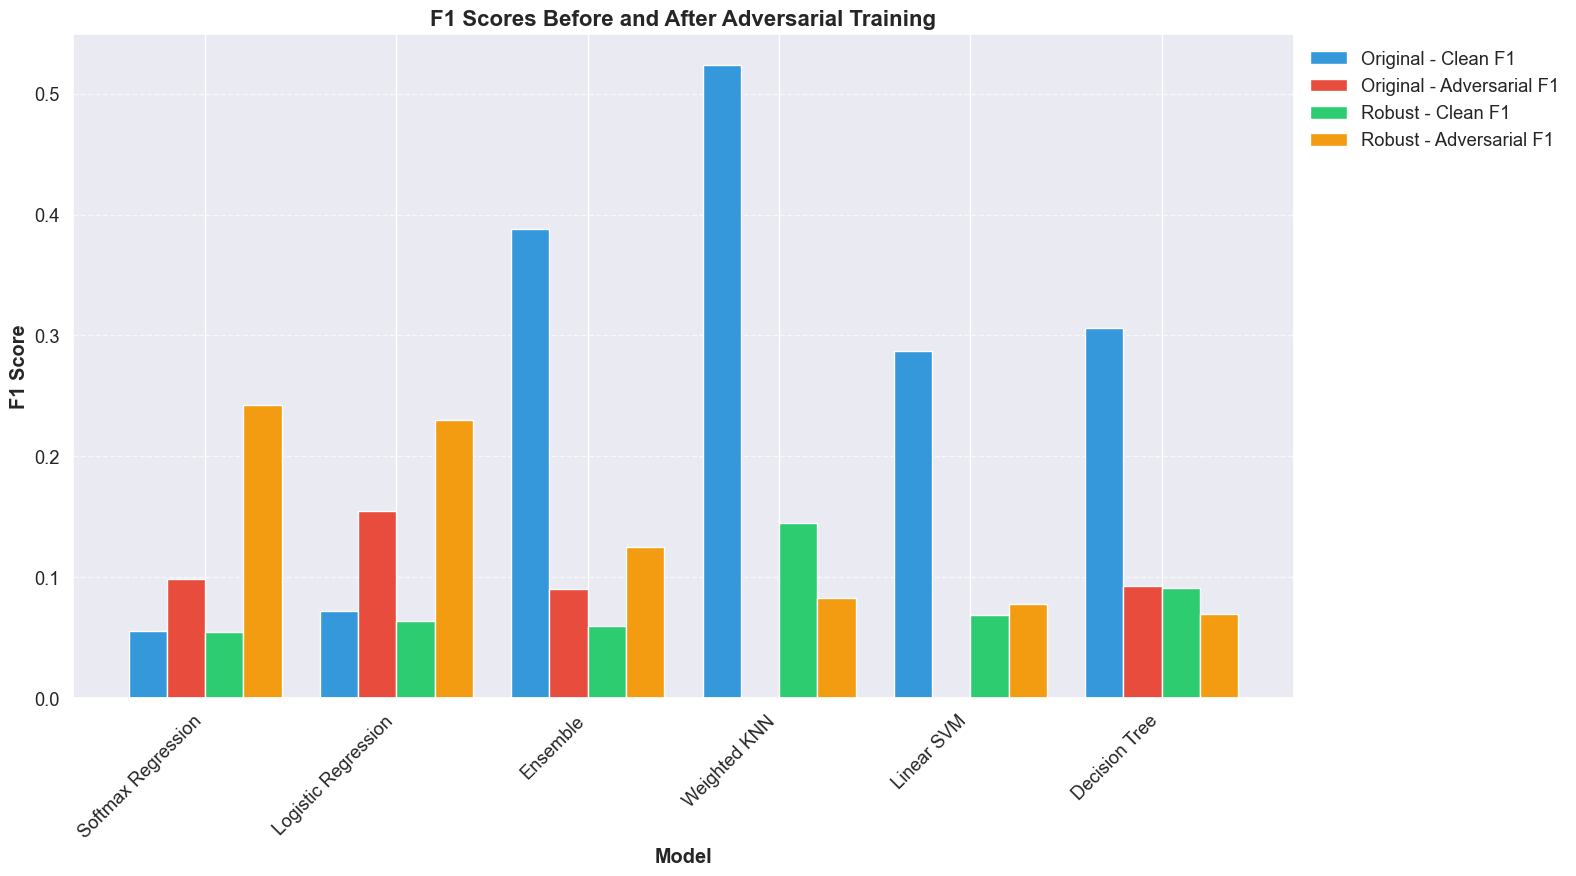

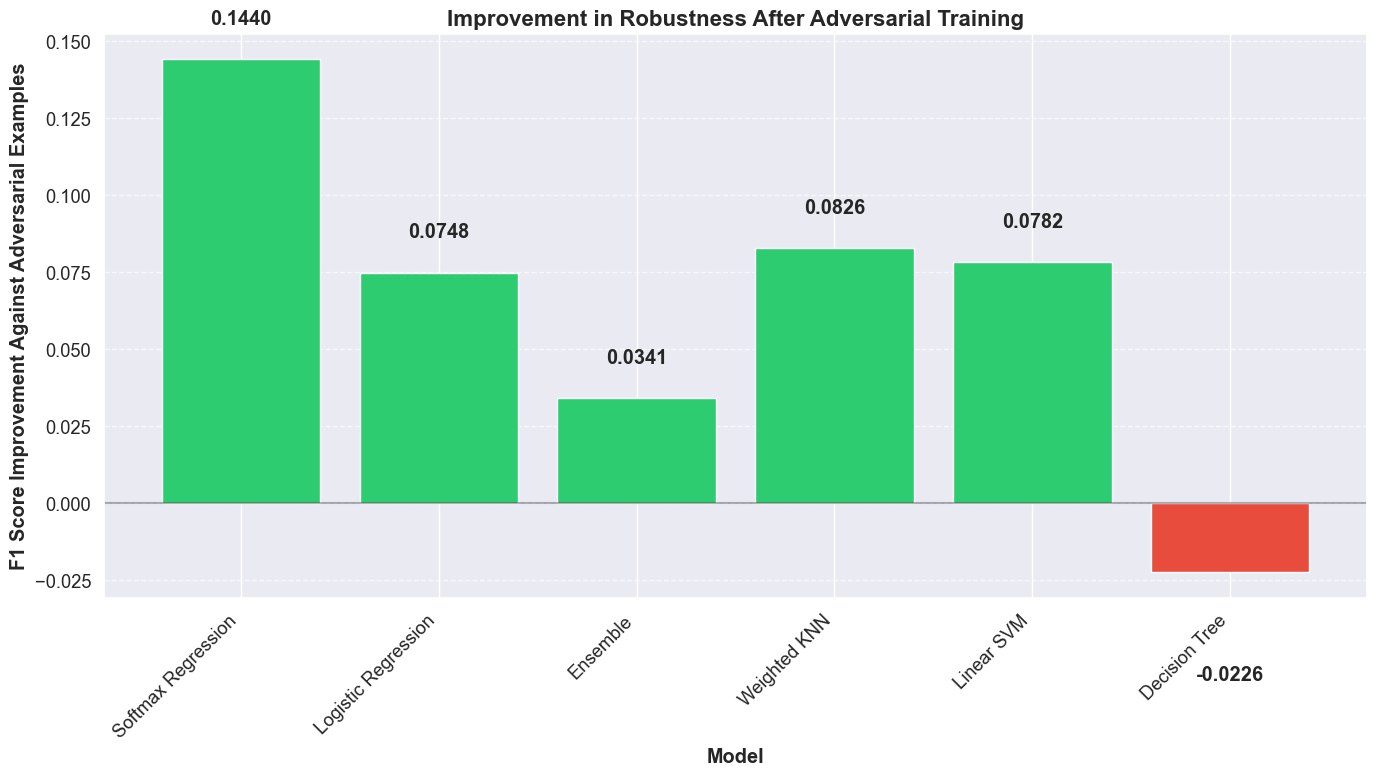

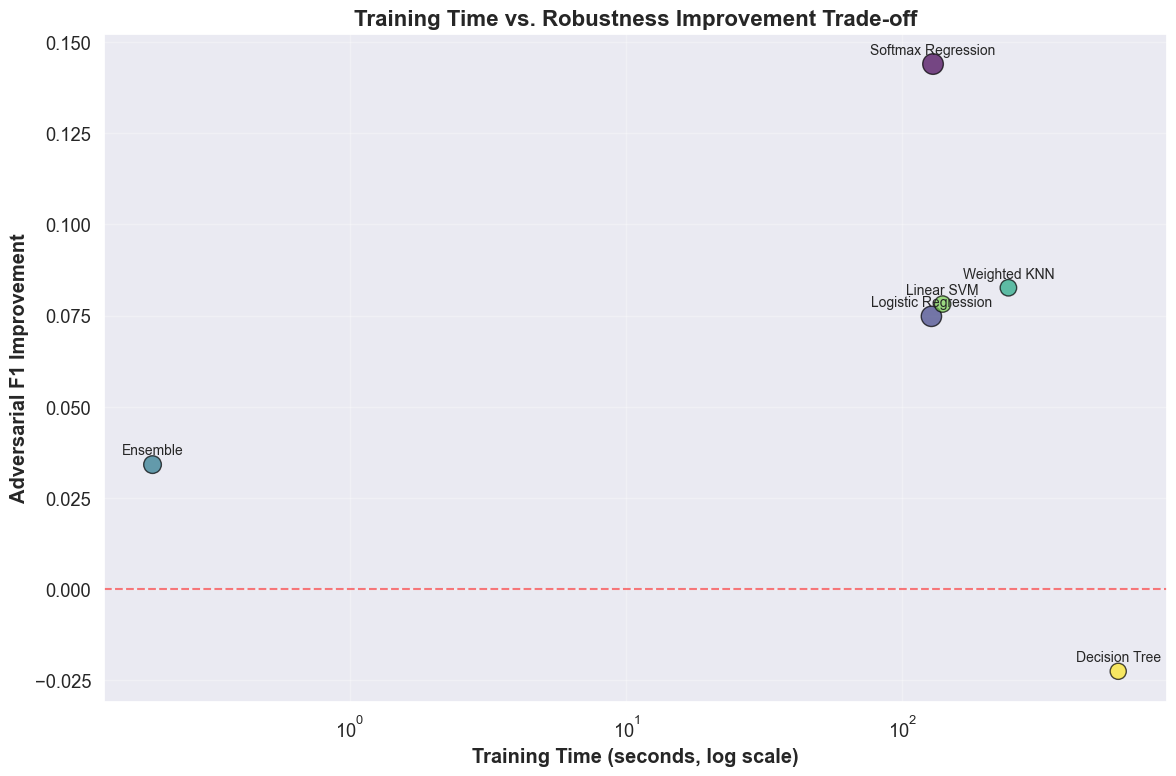

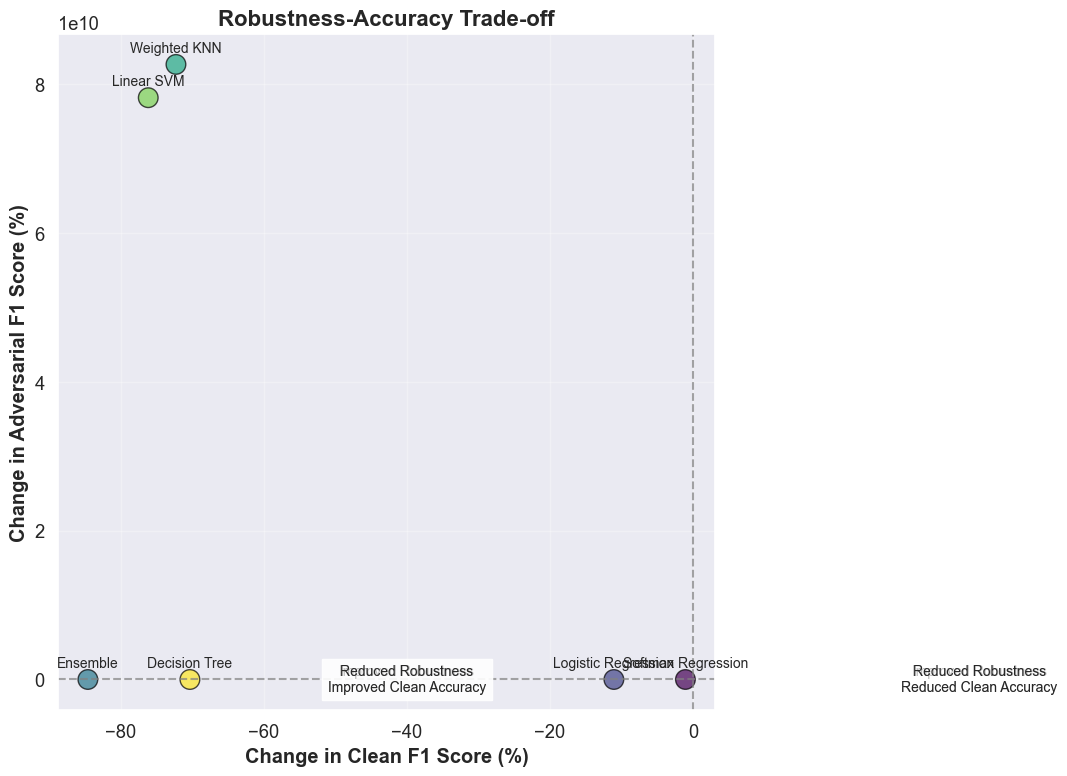

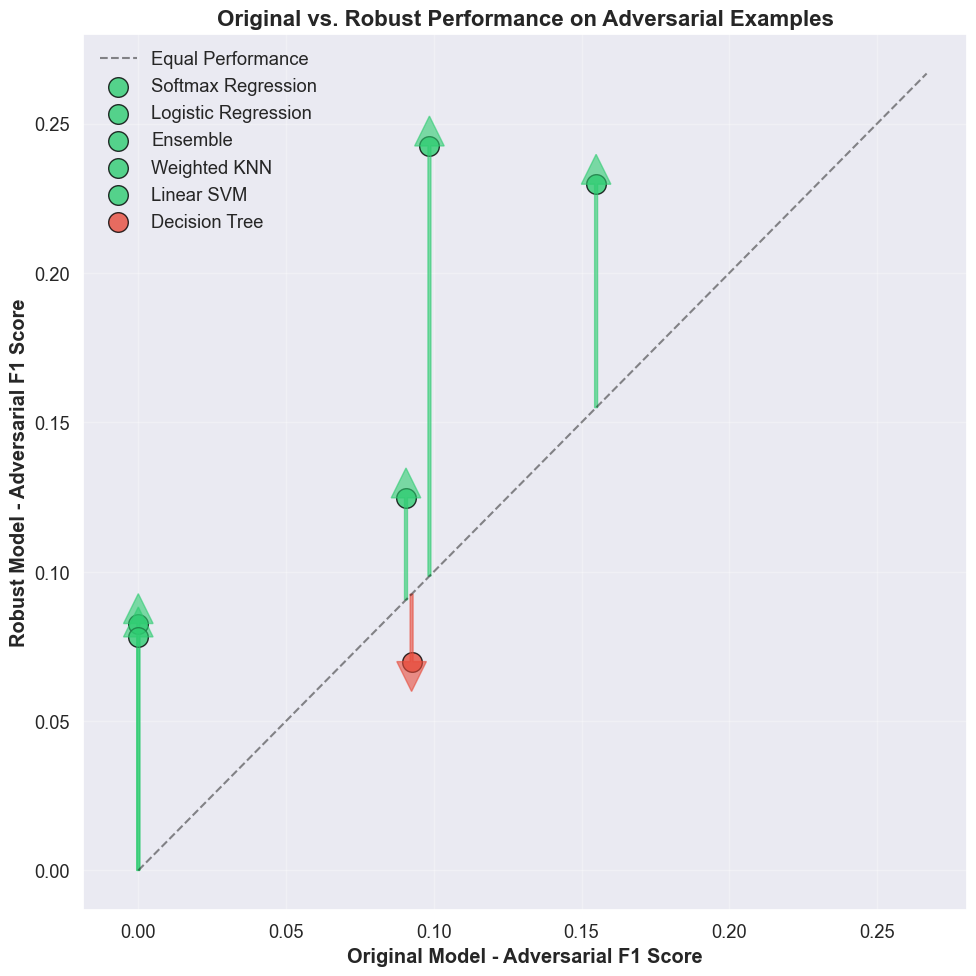

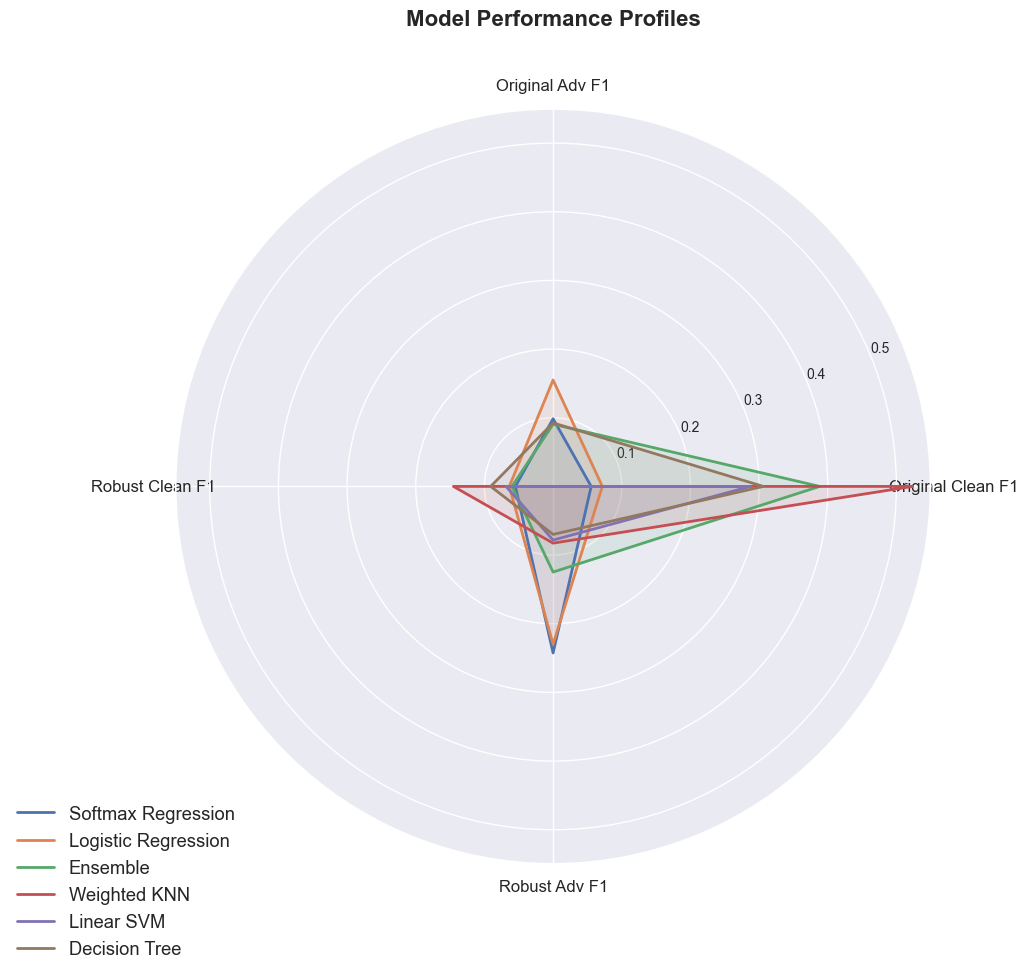

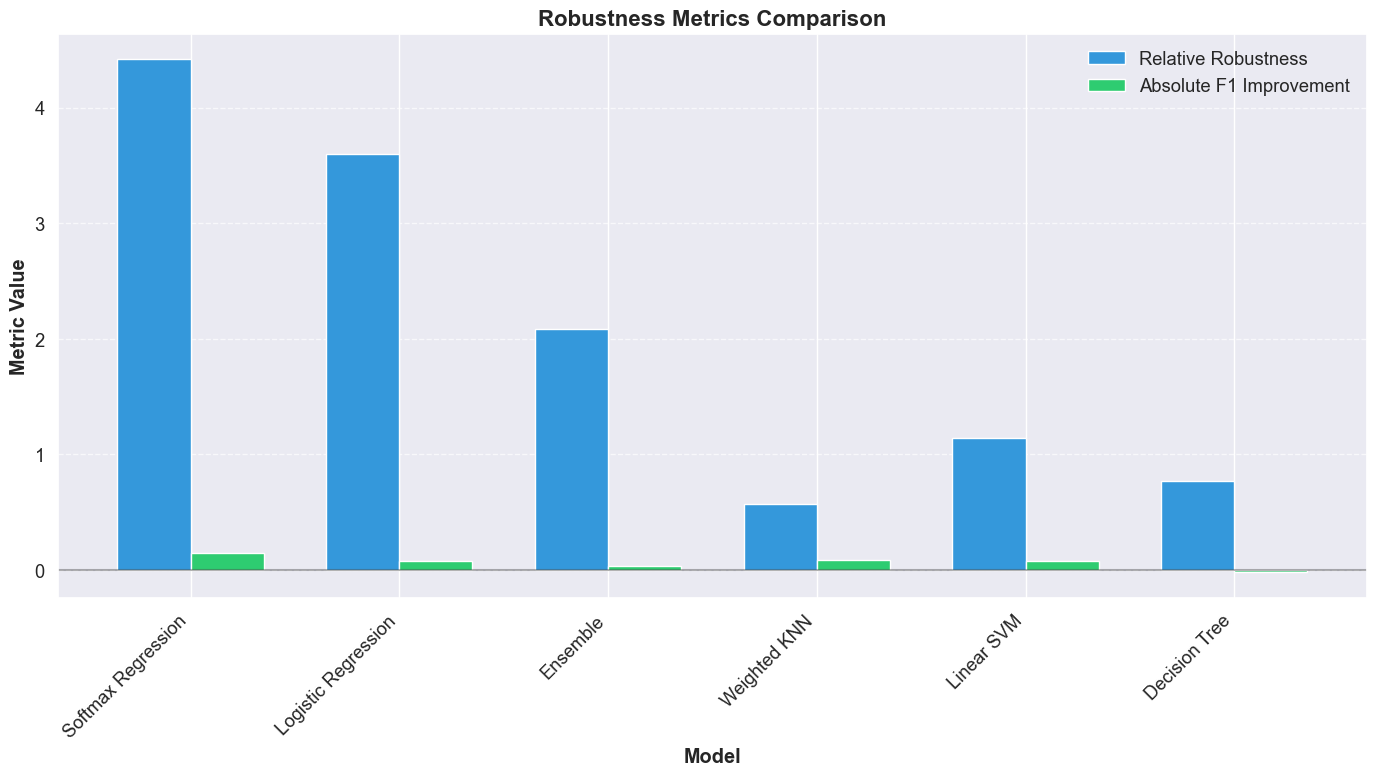

All visualizations have been saved to the 'adv_robust_plots' directory.


In [43]:
# Create directory for saving plots
plot_dir = "adv_robust_plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    print(f"Created directory: {plot_dir}")
else:
    print(f"Directory already exists: {plot_dir}")

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
colors = plt.cm.viridis(np.linspace(0, 1, 6))
model_colors = dict(zip(adv_training_df['model'].unique(), colors))

# Load results if needed (they're already in memory from previous cell)
# adv_training_df = pd.read_csv("adversarial_training_defense_results.csv")

# Sort models by robustness improvement for consistent ordering in plots
model_order = adv_training_df.sort_values(by=['robust_adv_f1'], ascending=False)['model'].values

# 1. Clean vs Adversarial F1 Scores
plt.figure(figsize=(16, 9))
bar_width = 0.2
x = np.arange(len(model_order))

# Get data for each category
clean_f1_orig = [adv_training_df[adv_training_df['model'] == model]['orig_clean_f1'].values[0] for model in model_order]
adv_f1_orig = [adv_training_df[adv_training_df['model'] == model]['orig_adv_f1'].values[0] for model in model_order]
clean_f1_robust = [adv_training_df[adv_training_df['model'] == model]['robust_clean_f1'].values[0] for model in model_order]
adv_f1_robust = [adv_training_df[adv_training_df['model'] == model]['robust_adv_f1'].values[0] for model in model_order]

# Plot bars
plt.bar(x - 1.5*bar_width, clean_f1_orig, bar_width, label='Original - Clean F1', color='#3498db')
plt.bar(x - 0.5*bar_width, adv_f1_orig, bar_width, label='Original - Adversarial F1', color='#e74c3c')
plt.bar(x + 0.5*bar_width, clean_f1_robust, bar_width, label='Robust - Clean F1', color='#2ecc71')
plt.bar(x + 1.5*bar_width, adv_f1_robust, bar_width, label='Robust - Adversarial F1', color='#f39c12')

# Add labels and legend
plt.xlabel('Model', fontweight='bold')
plt.ylabel('F1 Score', fontweight='bold')
plt.title('F1 Scores Before and After Adversarial Training', fontsize=16, fontweight='bold')
plt.xticks(x, model_order, rotation=45, ha='right')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"{plot_dir}/f1_score_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. Improvement in Adversarial Robustness
plt.figure(figsize=(14, 8))
improvement = [adv_training_df[adv_training_df['model'] == model]['robust_adv_f1'].values[0] - 
              adv_training_df[adv_training_df['model'] == model]['orig_adv_f1'].values[0] 
              for model in model_order]

# Create bars with color based on improvement value
colors = ['#2ecc71' if imp > 0 else '#e74c3c' for imp in improvement]
plt.bar(model_order, improvement, color=colors)

# Add horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add value labels on top of each bar
for i, imp in enumerate(improvement):
    plt.text(i, imp + (0.01 if imp > 0 else -0.03), 
             f"{imp:.4f}", ha='center', va='bottom' if imp > 0 else 'top',
             fontweight='bold')

plt.xlabel('Model', fontweight='bold')
plt.ylabel('F1 Score Improvement Against Adversarial Examples', fontweight='bold')
plt.title('Improvement in Robustness After Adversarial Training', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"{plot_dir}/robustness_improvement.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. Training Time vs. Robustness Improvement
plt.figure(figsize=(12, 8))
improvements = [adv_training_df[adv_training_df['model'] == model]['robust_adv_f1'].values[0] - 
               adv_training_df[adv_training_df['model'] == model]['orig_adv_f1'].values[0] 
               for model in model_order]
times = [adv_training_df[adv_training_df['model'] == model]['training_time'].values[0] for model in model_order]

# Create scatter plot with varying marker sizes based on overall performance
sizes = [adv_training_df[adv_training_df['model'] == model]['robust_adv_f1'].values[0] * 500 + 100 for model in model_order]

# Use different colors for each model
scatter = plt.scatter(times, improvements, s=sizes, alpha=0.7, 
                     c=range(len(model_order)), cmap='viridis', edgecolors='black')

# Add model labels
for i, model in enumerate(model_order):
    plt.annotate(model, (times[i], improvements[i]), 
                fontsize=10, ha='center', va='bottom', 
                xytext=(0, 5), textcoords='offset points')

plt.xscale('log')  # Log scale for better visualization of time differences
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)  # Line at y=0 for reference

plt.xlabel('Training Time (seconds, log scale)', fontweight='bold')
plt.ylabel('Adversarial F1 Improvement', fontweight='bold')
plt.title('Training Time vs. Robustness Improvement Trade-off', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{plot_dir}/training_time_vs_improvement.png", dpi=300, bbox_inches='tight')
plt.show()

# 4. Robustness-Accuracy Tradeoff
plt.figure(figsize=(12, 8))

# Calculate relative changes
clean_performance_change = [(adv_training_df[adv_training_df['model'] == model]['robust_clean_f1'].values[0] / 
                           adv_training_df[adv_training_df['model'] == model]['orig_clean_f1'].values[0] - 1) * 100 
                           for model in model_order]
adv_performance_change = [(adv_training_df[adv_training_df['model'] == model]['robust_adv_f1'].values[0] / 
                         (adv_training_df[adv_training_df['model'] == model]['orig_adv_f1'].values[0] + 1e-10) - 1) * 100  # Adding small value to avoid division by zero
                         for model in model_order]

# Create scatter plot with model-specific colors
scatter = plt.scatter(clean_performance_change, adv_performance_change, 
                     c=range(len(model_order)), cmap='viridis', 
                     s=200, alpha=0.7, edgecolors='black')

# Add model names as annotations
for i, model in enumerate(model_order):
    plt.annotate(model, (clean_performance_change[i], adv_performance_change[i]), 
                fontsize=10, ha='center', va='bottom',
                xytext=(0, 7), textcoords='offset points')

# Add quadrant lines
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

# Label quadrants
plt.text(40, 200, "Improved Robustness\nReduced Clean Accuracy", 
         ha='center', va='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
plt.text(-40, 200, "Improved Robustness\nImproved Clean Accuracy", 
         ha='center', va='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
plt.text(40, -100, "Reduced Robustness\nReduced Clean Accuracy", 
         ha='center', va='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
plt.text(-40, -100, "Reduced Robustness\nImproved Clean Accuracy", 
         ha='center', va='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

plt.xlabel('Change in Clean F1 Score (%)', fontweight='bold')
plt.ylabel('Change in Adversarial F1 Score (%)', fontweight='bold')
plt.title('Robustness-Accuracy Trade-off', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{plot_dir}/robustness_accuracy_tradeoff.png", dpi=300, bbox_inches='tight')
plt.show()

# 5. Original vs. Robust Performance on Adversarial Examples
plt.figure(figsize=(10, 10))
orig_adv_f1 = [adv_training_df[adv_training_df['model'] == model]['orig_adv_f1'].values[0] for model in model_order]
robust_adv_f1 = [adv_training_df[adv_training_df['model'] == model]['robust_adv_f1'].values[0] for model in model_order]

# Line of equality
max_val = max(max(orig_adv_f1), max(robust_adv_f1)) * 1.1
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Equal Performance')

# Scatter with model-specific colors
for i, model in enumerate(model_order):
    plt.scatter(orig_adv_f1[i], robust_adv_f1[i], s=200, color=colors[i], 
               label=model, alpha=0.8, edgecolors='black')
    
    # Add arrow to show improvement
    plt.arrow(orig_adv_f1[i], orig_adv_f1[i], 0, robust_adv_f1[i] - orig_adv_f1[i], 
             head_width=0.01, head_length=0.01, fc=colors[i], ec=colors[i], alpha=0.6)

plt.xlabel('Original Model - Adversarial F1 Score', fontweight='bold')
plt.ylabel('Robust Model - Adversarial F1 Score', fontweight='bold')
plt.title('Original vs. Robust Performance on Adversarial Examples', fontsize=16, fontweight='bold')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{plot_dir}/original_vs_robust_performance.png", dpi=300, bbox_inches='tight')
plt.show()

# 6. Radar Chart - Model Performance Profiles
from math import pi

plt.figure(figsize=(12, 10))
# Categories for radar chart
categories = ['Original Clean F1', 'Original Adv F1', 'Robust Clean F1', 'Robust Adv F1']
N = len(categories)

# Create angle for each category
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Initialize radar chart
ax = plt.subplot(111, polar=True)

# Add category labels
plt.xticks(angles[:-1], categories, fontsize=12)

# Plot each model
for i, model in enumerate(model_order):
    values = [
        adv_training_df[adv_training_df['model'] == model]['orig_clean_f1'].values[0],
        adv_training_df[adv_training_df['model'] == model]['orig_adv_f1'].values[0],
        adv_training_df[adv_training_df['model'] == model]['robust_clean_f1'].values[0],
        adv_training_df[adv_training_df['model'] == model]['robust_adv_f1'].values[0]
    ]
    values += values[:1]  # Close the loop
    
    # Plot values
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
    ax.fill(angles, values, alpha=0.1)

# Customize radar chart
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5], ['0.1', '0.2', '0.3', '0.4', '0.5'], fontsize=10)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Model Performance Profiles', fontsize=16, fontweight='bold', y=1.1)
plt.tight_layout()
plt.savefig(f"{plot_dir}/model_performance_radar.png", dpi=300, bbox_inches='tight')
plt.show()

# 7. Combined improvement and robustness metrics
plt.figure(figsize=(14, 8))
x = np.arange(len(model_order))
bar_width = 0.35

# Calculate relative robustness (how much of adversarial attack is mitigated)
rel_robustness = [(adv_training_df[adv_training_df['model'] == model]['robust_adv_f1'].values[0] / 
                  adv_training_df[adv_training_df['model'] == model]['robust_clean_f1'].values[0])
                  for model in model_order]

# Calculate absolute improvement
abs_improvement = [adv_training_df[adv_training_df['model'] == model]['robust_adv_f1'].values[0] - 
                  adv_training_df[adv_training_df['model'] == model]['orig_adv_f1'].values[0] 
                  for model in model_order]

# Plot bars
plt.bar(x - bar_width/2, rel_robustness, bar_width, label='Relative Robustness', color='#3498db')
plt.bar(x + bar_width/2, abs_improvement, bar_width, label='Absolute F1 Improvement', color='#2ecc71')

# Add horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.xlabel('Model', fontweight='bold')
plt.xticks(x, model_order, rotation=45, ha='right')
plt.ylabel('Metric Value', fontweight='bold')
plt.title('Robustness Metrics Comparison', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"{plot_dir}/robustness_metrics_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"All visualizations have been saved to the '{plot_dir}' directory.")

#### Defensive Preprocessing

In [44]:
# Parameters for defensive preprocessing
preproc_params = {
    'defense_types': ['quantization', 'noise', 'median_filter', 'combined'],
    'strength': 0.1,
    'sample_size': 50,  # Number of samples to use in evaluation
}

# Define defense strengths to try
defense_strengths = [0.05, 0.1, 0.15]

In [52]:
print("\n" + "="*70)
print("IMPLEMENTING DEFENSIVE PREPROCESSING DEFENSE")
print("="*70)
print(f"Attack function: {attack_func.__name__}")
print(f"Defense types: {preproc_params['defense_types']}")

# Use existing ensemble model
print("\nUsing existing ensemble model...")

# Create directory for saving preprocessing models if it doesn't exist
if not os.path.exists('preproc_defense_models'):
    os.makedirs('preproc_defense_models')
    print(f"Created directory: preproc_defense_models")

# List to collect results
preprocessing_results = []

# Process each model
for model_name, base_model in all_models.items():
    print(f"\n{'-'*50}")
    print(f"Processing {model_name}...")
    
    # Select appropriate features based on model
    if model_name != 'Weighted KNN':
        test_features = X_test_scaled
    else:
        test_features = X_test_reduced
    
    # Try each defense type
    for defense_type in preproc_params['defense_types']:
        # Try different strengths for each defense type
        for strength in defense_strengths:
            print(f"Testing {defense_type} defense with strength {strength}...")
            
            # Time the process
            start_time = time.time()
            
            # Create defensive preprocessor
            preprocessor = DefensivePreprocessor(defense_type=defense_type, strength=strength)
            
            # Create defensive wrapper around the model
            robust_model = DefensiveWrapper(base_model, preprocessor)
            
            # Save the defensive preprocessor model
            preprocessor_path = f"preproc_defense_models/{model_name.replace(' ', '_').lower()}_{defense_type}_{strength}.pkl"
            joblib.dump(preprocessor, preprocessor_path)
            
            # Measure time
            preprocessing_time = time.time() - start_time
            
            # Evaluate defense effectiveness
            print(f"Evaluating effectiveness...")
            metrics = evaluate_defense(
                defense_name=f"Preprocessing ({defense_type}, {strength}) - {model_name}",
                original_model=base_model,
                robust_model=robust_model,
                X_test=test_features,
                y_test=test_labels,
                attack_func=attack_func,
                epsilon=0.2,  # Using consistent attack strength
                sample_size=preproc_params['sample_size']
            )
            
            # Add model name, defense type, and processing time to metrics
            metrics['model'] = model_name
            metrics['defense_type'] = defense_type
            metrics['strength'] = strength
            metrics['processing_time'] = preprocessing_time
            
            # Add to results
            preprocessing_results.append(metrics)
            
            # Print key metrics
            print(f"Original model F1 on adversarial examples: {metrics['orig_adv_f1']:.4f}")
            print(f"Robust model F1 on adversarial examples: {metrics['robust_adv_f1']:.4f}")
            print(f"Improvement: {metrics['robust_adv_f1'] - metrics['orig_adv_f1']:.4f}")

# Convert results to DataFrame
preprocessing_df = pd.DataFrame(preprocessing_results)

# Save results to CSV
csv_path = "preprocessing_defense_results.csv"
preprocessing_df.to_csv(csv_path, index=False)
print(f"\nResults saved to {csv_path}")

# Find best defense configuration for each model
best_configs = []
for model_name in all_models.keys():
    model_results = preprocessing_df[preprocessing_df['model'] == model_name]
    if not model_results.empty:
        # Get configuration with highest robust F1 score on adversarial examples
        best_idx = model_results['robust_adv_f1'].idxmax()
        best_configs.append(model_results.loc[best_idx])

best_configs_df = pd.DataFrame(best_configs)

# Display summary table
print("\nBest Defensive Preprocessing Configuration by Model:")
summary_columns = ['model', 'defense_type', 'strength', 'orig_clean_f1', 'orig_adv_f1', 
                  'robust_clean_f1', 'robust_adv_f1']
summary_df = best_configs_df[summary_columns].sort_values(by=['robust_adv_f1'], ascending=False)
print(summary_df.to_string(index=False))


IMPLEMENTING DEFENSIVE PREPROCESSING DEFENSE
Attack function: adv_boundary_attack
Defense types: ['quantization', 'noise', 'median_filter', 'combined']

Using existing ensemble model...
Created directory: preproc_defense_models

--------------------------------------------------
Processing Linear SVM...
Testing quantization defense with strength 0.05...
Evaluating effectiveness...
Original model F1 on adversarial examples: 0.0000
Robust model F1 on adversarial examples: 0.0074
Improvement: 0.0074
Testing quantization defense with strength 0.1...
Evaluating effectiveness...
Original model F1 on adversarial examples: 0.0000
Robust model F1 on adversarial examples: 0.0000
Improvement: 0.0000
Testing quantization defense with strength 0.15...
Evaluating effectiveness...
Original model F1 on adversarial examples: 0.0000
Robust model F1 on adversarial examples: 0.0000
Improvement: 0.0000
Testing noise defense with strength 0.05...
Evaluating effectiveness...
Original model F1 on adversarial

Created directory: preproc_defense_plots


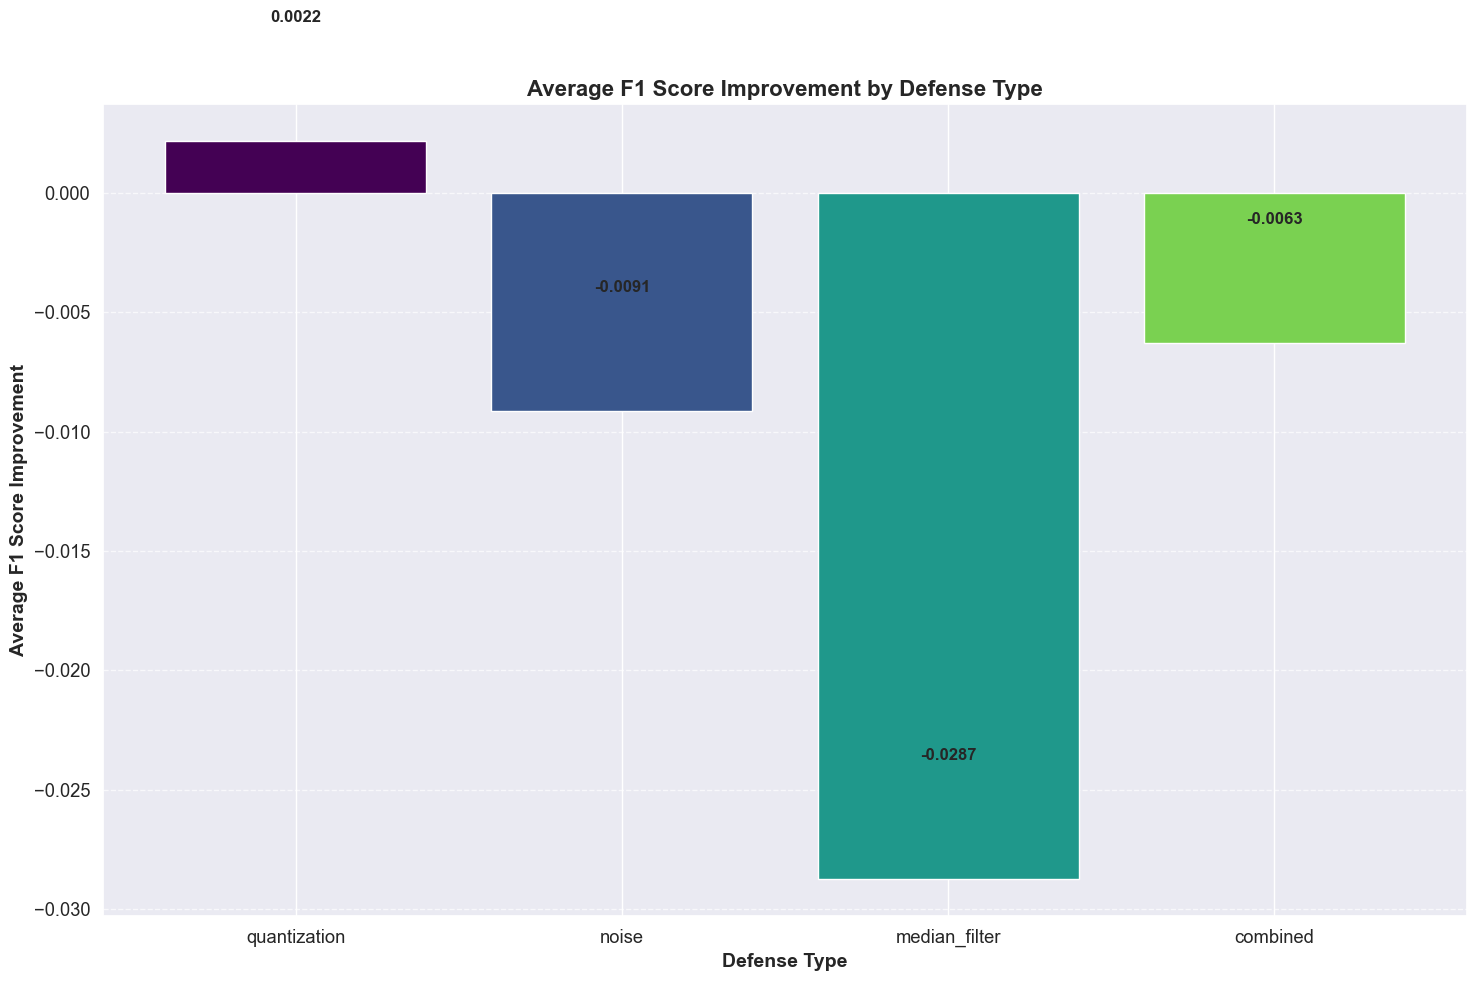

<Figure size 1500x1000 with 0 Axes>

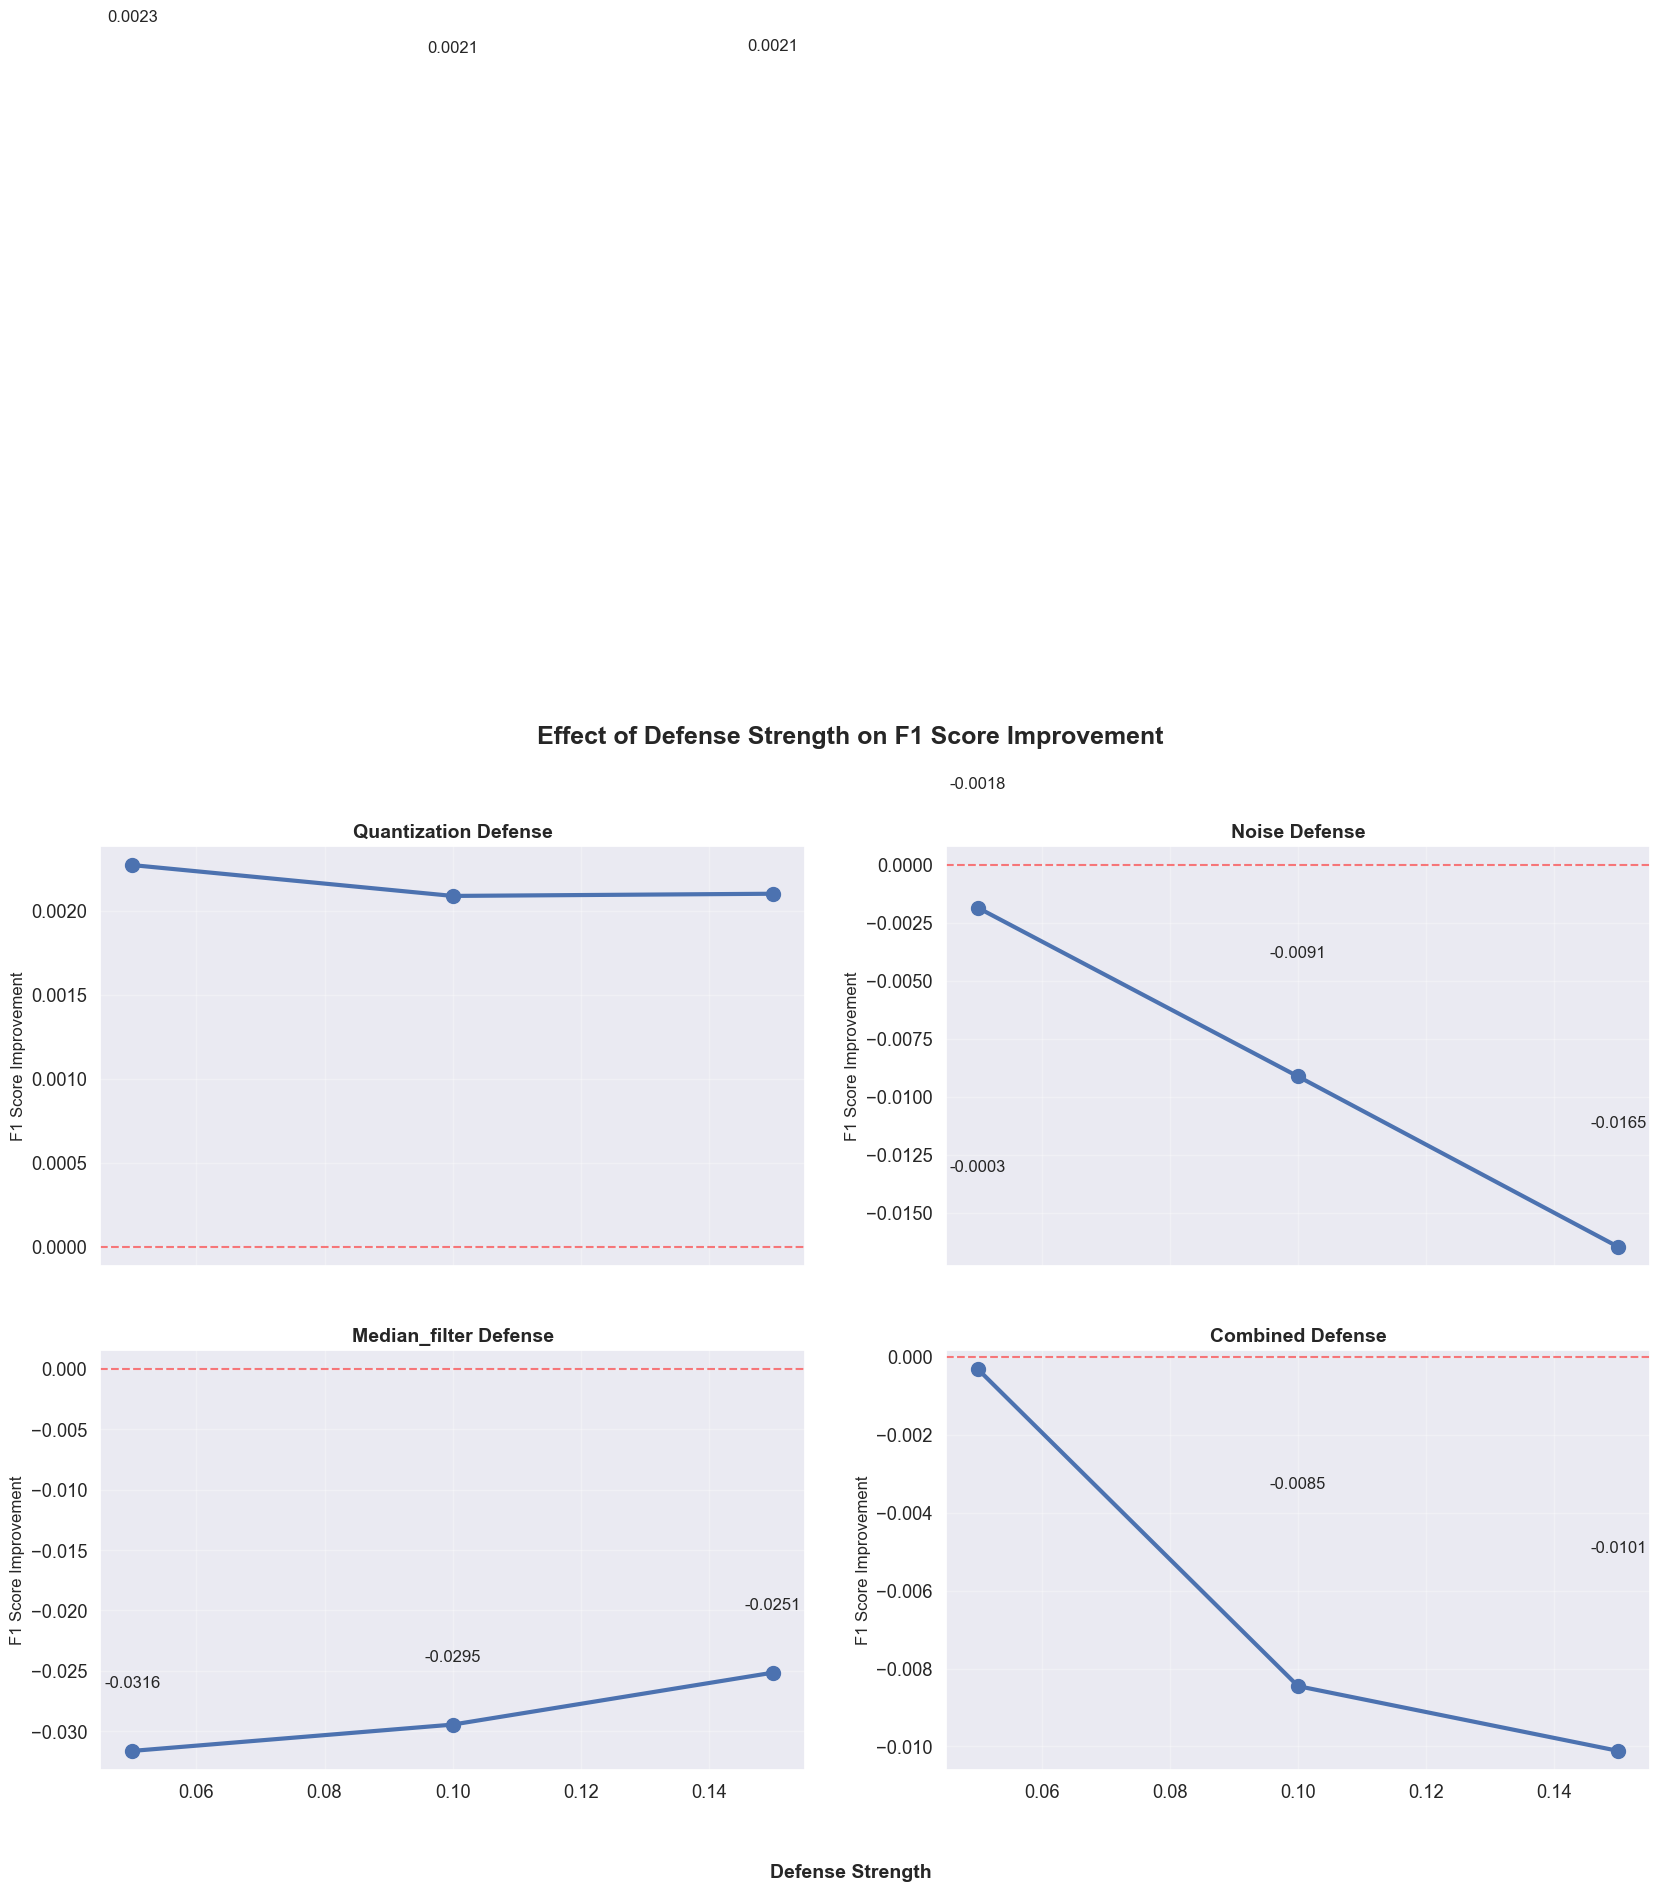

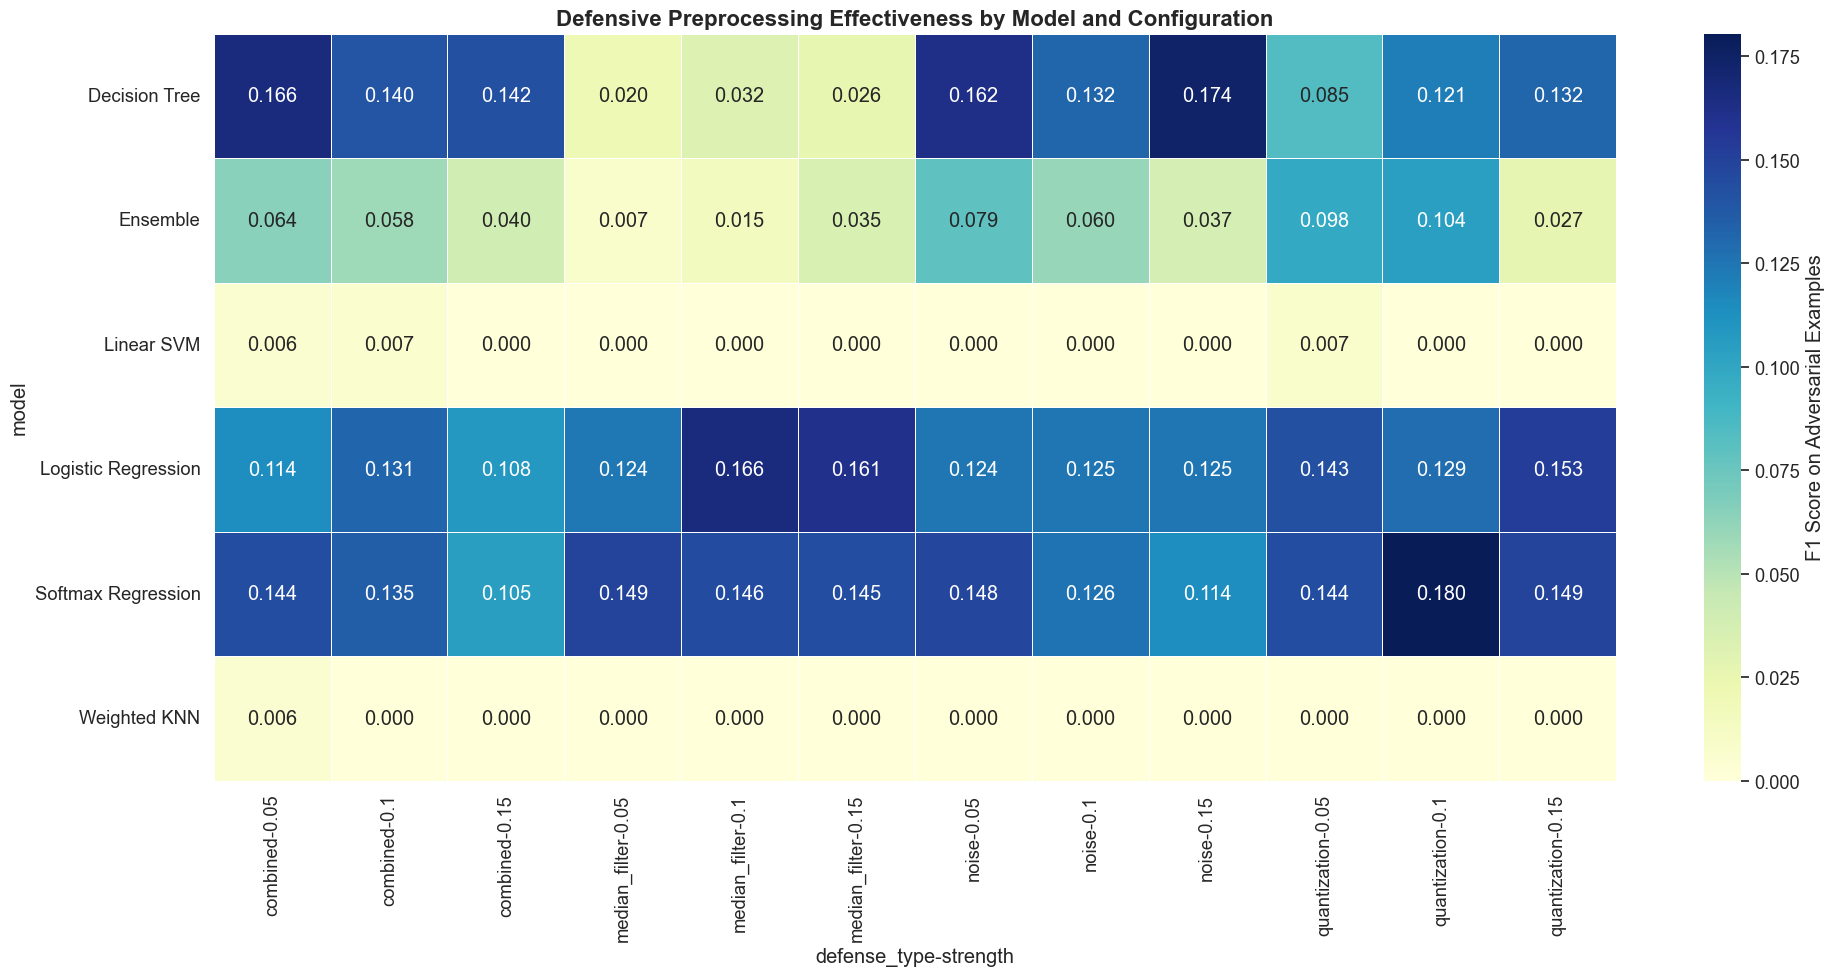

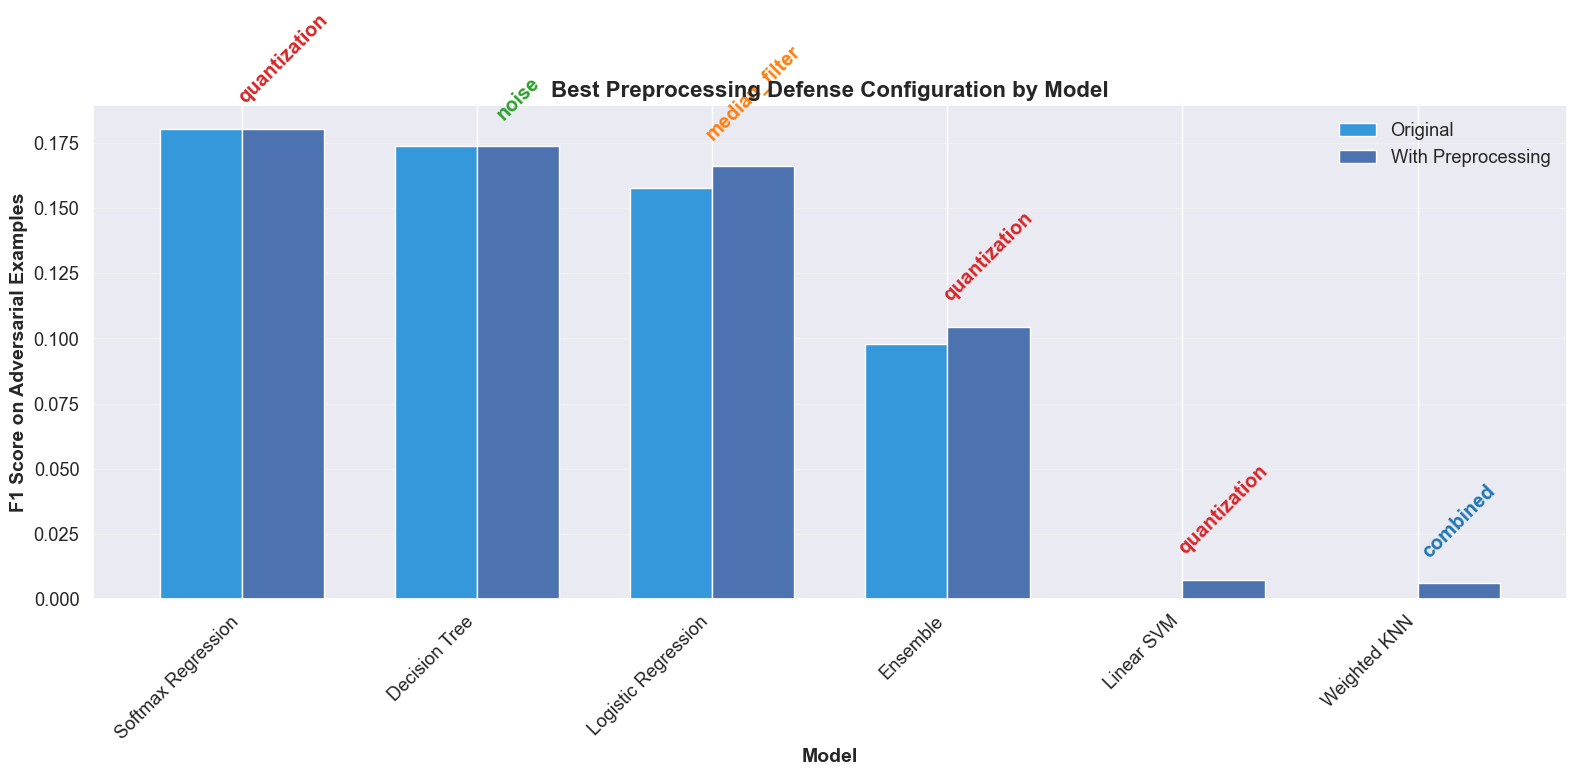

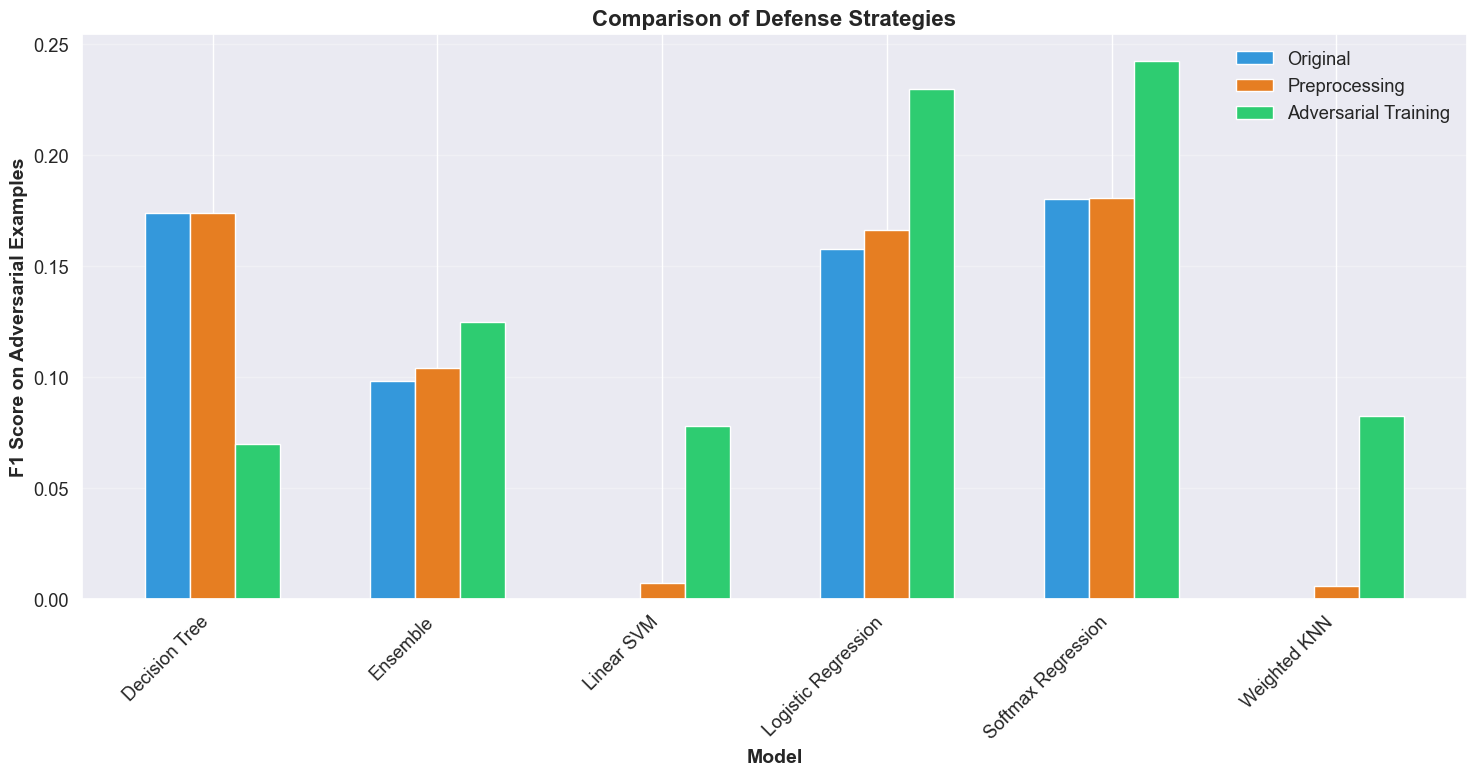

All preprocessing defense visualizations have been saved to the 'preproc_defense_plots' directory.


In [53]:
# Create directory for preprocessing plots
preproc_plot_dir = "preproc_defense_plots"
if not os.path.exists(preproc_plot_dir):
    os.makedirs(preproc_plot_dir)
    print(f"Created directory: {preproc_plot_dir}")

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# 1. Effectiveness by Defense Type
plt.figure(figsize=(15, 10))

# Group data by defense type
defense_types = preprocessing_df['defense_type'].unique()
models = preprocessing_df['model'].unique()

# Average improvement by defense type
defense_improvements = []
for defense in defense_types:
    defense_data = preprocessing_df[preprocessing_df['defense_type'] == defense]
    avg_improvement = defense_data['robust_adv_f1'] - defense_data['orig_adv_f1']
    defense_improvements.append(avg_improvement.mean())

# Create bar chart
bars = plt.bar(defense_types, defense_improvements, color=plt.cm.viridis(np.linspace(0, 0.8, len(defense_types))))

# Add labels and annotations
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f"{defense_improvements[i]:.4f}", ha='center', fontsize=12, fontweight='bold')

plt.title('Average F1 Score Improvement by Defense Type', fontsize=16, fontweight='bold')
plt.xlabel('Defense Type', fontsize=14, fontweight='bold')
plt.ylabel('Average F1 Score Improvement', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"{preproc_plot_dir}/defense_type_effectiveness.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. Defense Strength Comparison
plt.figure(figsize=(15, 10))

# Create separate subplot for each defense type
fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharex=True)
axes = axes.flatten()

for i, defense_type in enumerate(defense_types):
    ax = axes[i]
    defense_data = preprocessing_df[preprocessing_df['defense_type'] == defense_type]
    
    # Group by strength
    grouped_data = defense_data.groupby(['strength']).agg({'robust_adv_f1': 'mean', 'orig_adv_f1': 'mean'}).reset_index()
    
    # Calculate improvement
    grouped_data['improvement'] = grouped_data['robust_adv_f1'] - grouped_data['orig_adv_f1']
    
    # Plot line
    ax.plot(grouped_data['strength'], grouped_data['improvement'], 'o-', linewidth=3, markersize=10)
    
    # Add points
    for x, y in zip(grouped_data['strength'], grouped_data['improvement']):
        ax.text(x, y + 0.005, f"{y:.4f}", ha='center', va='bottom', fontsize=12)
    
    ax.set_title(f"{defense_type.capitalize()} Defense", fontsize=14, fontweight='bold')
    ax.set_ylabel('F1 Score Improvement', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Add horizontal line at y=0
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Set common x-axis label
fig.text(0.5, 0.02, 'Defense Strength', ha='center', fontsize=14, fontweight='bold')
fig.suptitle('Effect of Defense Strength on F1 Score Improvement', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f"{preproc_plot_dir}/defense_strength_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. Model-specific Defense Effectiveness
plt.figure(figsize=(20, 10))

# Create a heatmap showing defense effectiveness for each model
pivot_data = preprocessing_df.pivot_table(
    values='robust_adv_f1', 
    index='model', 
    columns=['defense_type', 'strength'],
    aggfunc='mean'
)

# Plot heatmap
sns.heatmap(pivot_data, annot=True, fmt=".3f", cmap="YlGnBu", linewidths=0.5, 
           cbar_kws={'label': 'F1 Score on Adversarial Examples'})
plt.title('Defensive Preprocessing Effectiveness by Model and Configuration', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{preproc_plot_dir}/model_defense_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# 4. Best Configuration by Model
plt.figure(figsize=(16, 8))
model_order = best_configs_df.sort_values(by='robust_adv_f1', ascending=False)['model'].values
x = np.arange(len(model_order))
bar_width = 0.35

# Get data
orig_adv_f1 = [best_configs_df[best_configs_df['model'] == model]['orig_adv_f1'].values[0] for model in model_order]
robust_adv_f1 = [best_configs_df[best_configs_df['model'] == model]['robust_adv_f1'].values[0] for model in model_order]
defense_types = [best_configs_df[best_configs_df['model'] == model]['defense_type'].values[0] for model in model_order]

# Create color map based on defense type
unique_defenses = np.unique(defense_types)
defense_colors = dict(zip(unique_defenses, plt.cm.tab10(range(len(unique_defenses)))))
bar_colors = [defense_colors[d] for d in defense_types]

# Plot bars
plt.bar(x - bar_width/2, orig_adv_f1, bar_width, label='Original', color='#3498db')
plt.bar(x + bar_width/2, robust_adv_f1, bar_width, label='With Preprocessing')

# Add defense type as text above each bar
for i, (defense, r_f1) in enumerate(zip(defense_types, robust_adv_f1)):
    plt.text(i + bar_width/2, r_f1 + 0.01, defense, ha='center', rotation=45, 
             fontweight='bold', color=defense_colors[defense])

# Add labels and customize
plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.ylabel('F1 Score on Adversarial Examples', fontsize=14, fontweight='bold')
plt.title('Best Preprocessing Defense Configuration by Model', fontsize=16, fontweight='bold')
plt.xticks(x, model_order, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f"{preproc_plot_dir}/best_configurations.png", dpi=300, bbox_inches='tight')
plt.show()

# 5. Compare preprocessing with adversarial training
if 'adv_training_df' in globals():
    plt.figure(figsize=(15, 8))
    
    # Get the models present in both datasets
    common_models = list(set(preprocessing_df['model'].unique()) & 
                        set(adv_training_df['model'].unique()))
    common_models.sort()
    
    x = np.arange(len(common_models))
    bar_width = 0.2
    
    # Get the best preprocessing configuration for each model
    best_preproc = best_configs_df[best_configs_df['model'].isin(common_models)]
    
    # Get data for both defense methods
    orig_f1 = [best_preproc[best_preproc['model'] == model]['orig_adv_f1'].values[0] for model in common_models]
    preproc_f1 = [best_preproc[best_preproc['model'] == model]['robust_adv_f1'].values[0] for model in common_models]
    adv_train_f1 = [adv_training_df[adv_training_df['model'] == model]['robust_adv_f1'].values[0] for model in common_models]
    
    # Plot bars
    plt.bar(x - bar_width, orig_f1, bar_width, label='Original', color='#3498db')
    plt.bar(x, preproc_f1, bar_width, label='Preprocessing', color='#e67e22')
    plt.bar(x + bar_width, adv_train_f1, bar_width, label='Adversarial Training', color='#2ecc71')
    
    # Add labels and customize
    plt.xlabel('Model', fontsize=14, fontweight='bold')
    plt.ylabel('F1 Score on Adversarial Examples', fontsize=14, fontweight='bold')
    plt.title('Comparison of Defense Strategies', fontsize=16, fontweight='bold')
    plt.xticks(x, common_models, rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{preproc_plot_dir}/defense_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

print(f"All preprocessing defense visualizations have been saved to the '{preproc_plot_dir}' directory.")

#### Robust Ensemble

In [54]:
print("\n" + "="*70)
print("IMPLEMENTING ROBUST ENSEMBLE DEFENSE")
print("="*70)
print(f"Using optimal preprocessors from previous defensive preprocessing evaluation")

# Parameters for robust ensemble evaluation
robust_ensemble_params = {
    'sample_size': 50,  # Number of samples to use in evaluation
    'defense_type': 'ensemble',
}

# Create directory for saving robust ensemble models if it doesn't exist
if not os.path.exists('robust_ensemble_models'):
    os.makedirs('robust_ensemble_models')
    print(f"Created directory: robust_ensemble_models")

# Time the process
start_time = time.time()

# Get the best preprocessing configuration for each model from previous results
print("\nLoading best defensive preprocessors for each model...")

if 'best_configs_df' not in globals():
    # If best_configs_df isn't in memory, try to regenerate it from preprocesssing_df
    if 'preprocessing_df' in globals():
        best_configs = []
        for model_name in all_models.keys():
            model_results = preprocessing_df[preprocessing_df['model'] == model_name]
            if not model_results.empty:
                best_idx = model_results['robust_adv_f1'].idxmax()
                best_configs.append(model_results.loc[best_idx])
        best_configs_df = pd.DataFrame(best_configs)
    else:
        # If neither is available, load from CSV
        preprocessing_df = pd.read_csv("preprocessing_defense_results.csv")
        best_configs = []
        for model_name in all_models.keys():
            model_results = preprocessing_df[preprocessing_df['model'] == model_name]
            if not model_results.empty:
                best_idx = model_results['robust_adv_f1'].idxmax()
                best_configs.append(model_results.loc[best_idx])
        best_configs_df = pd.DataFrame(best_configs)

# Create the components for the robust ensemble
defensive_models = {}

for _, row in best_configs_df.iterrows():
    model_name = row['model']
    defense_type = row['defense_type']
    strength = row['strength']
    
    # Only include models using full features (exclude KNN)
    if model_name != 'Weighted KNN':
        try:
            # Load the base model
            base_model = trained_base_models[model_name]
            
            # Load or recreate the preprocessor
            preprocessor_path = f"preproc_defense_models/{model_name.replace(' ', '_').lower()}_{defense_type}_{strength}.pkl"
            
            if os.path.exists(preprocessor_path):
                print(f"Loading preprocessor: {preprocessor_path}")
                preprocessor = joblib.load(preprocessor_path)
            else:
                print(f"Creating new preprocessor with {defense_type}, strength={strength}")
                preprocessor = DefensivePreprocessor(defense_type=defense_type, strength=strength)
            
            # Create a defensive wrapper
            defensive_model = DefensiveWrapper(base_model, preprocessor)
            defensive_models[model_name] = defensive_model
            print(f"✓ Added {model_name} with {defense_type} defense (strength={strength})")
            
        except Exception as e:
            print(f"✗ Error processing {model_name}: {str(e)}")

# Create the robust ensemble
print(f"\nCreating robust ensemble from {len(defensive_models)} defensive models...")
robust_ensemble = RobustEnsembleModel(defensive_models)

# Save the robust ensemble
robust_ensemble_path = "robust_ensemble_models/robust_ensemble.pkl"
joblib.dump(robust_ensemble, robust_ensemble_path)
print(f"Saved robust ensemble to {robust_ensemble_path}")

ensemble_creation_time = time.time() - start_time
print(f"Ensemble creation completed in {ensemble_creation_time:.2f} seconds")

# Evaluate the robust ensemble
print("\nEvaluating robust ensemble effectiveness...")
metrics = evaluate_defense(
    defense_name="Robust Ensemble",
    original_model=ensemble_model,  # Original ensemble model without defenses
    robust_model=robust_ensemble,   # Robust ensemble with diverse defenses
    X_test=X_test_scaled,
    y_test=test_labels,
    attack_func=attack_func,
    epsilon=0.2,  # Using consistent attack strength
    sample_size=robust_ensemble_params['sample_size']
)

# Add model name and processing time to metrics
metrics['model'] = 'Robust Ensemble'
metrics['defense_type'] = robust_ensemble_params['defense_type']
metrics['creation_time'] = ensemble_creation_time

# Save results to CSV
csv_path = "robust_ensemble_results.csv"
ensemble_df = pd.DataFrame([metrics])
ensemble_df.to_csv(csv_path, index=False)
print(f"\nResults saved to {csv_path}")

# Print key metrics
print(f"\nOriginal ensemble F1 on clean examples: {metrics['orig_clean_f1']:.4f}")
print(f"Original ensemble F1 on adversarial examples: {metrics['orig_adv_f1']:.4f}")
print(f"Robust ensemble F1 on clean examples: {metrics['robust_clean_f1']:.4f}")
print(f"Robust ensemble F1 on adversarial examples: {metrics['robust_adv_f1']:.4f}")
print(f"Improvement on adversarial examples: {metrics['robust_adv_f1'] - metrics['orig_adv_f1']:.4f}")


IMPLEMENTING ROBUST ENSEMBLE DEFENSE
Using optimal preprocessors from previous defensive preprocessing evaluation
Created directory: robust_ensemble_models

Loading best defensive preprocessors for each model...
Loading preprocessor: preproc_defense_models/linear_svm_quantization_0.05.pkl
✓ Added Linear SVM with quantization defense (strength=0.05)
Loading preprocessor: preproc_defense_models/logistic_regression_median_filter_0.1.pkl
✓ Added Logistic Regression with median_filter defense (strength=0.1)
Loading preprocessor: preproc_defense_models/softmax_regression_quantization_0.1.pkl
✓ Added Softmax Regression with quantization defense (strength=0.1)
Loading preprocessor: preproc_defense_models/decision_tree_noise_0.15.pkl
✓ Added Decision Tree with noise defense (strength=0.15)
✗ Error processing Ensemble: 'Ensemble'

Creating robust ensemble from 4 defensive models...
Saved robust ensemble to robust_ensemble_models/robust_ensemble.pkl
Ensemble creation completed in 0.39 seconds

E

Created directory: robust_ensemble_plots

Comparing all defense strategies...
Comparison results saved to defense_strategy_comparison.csv


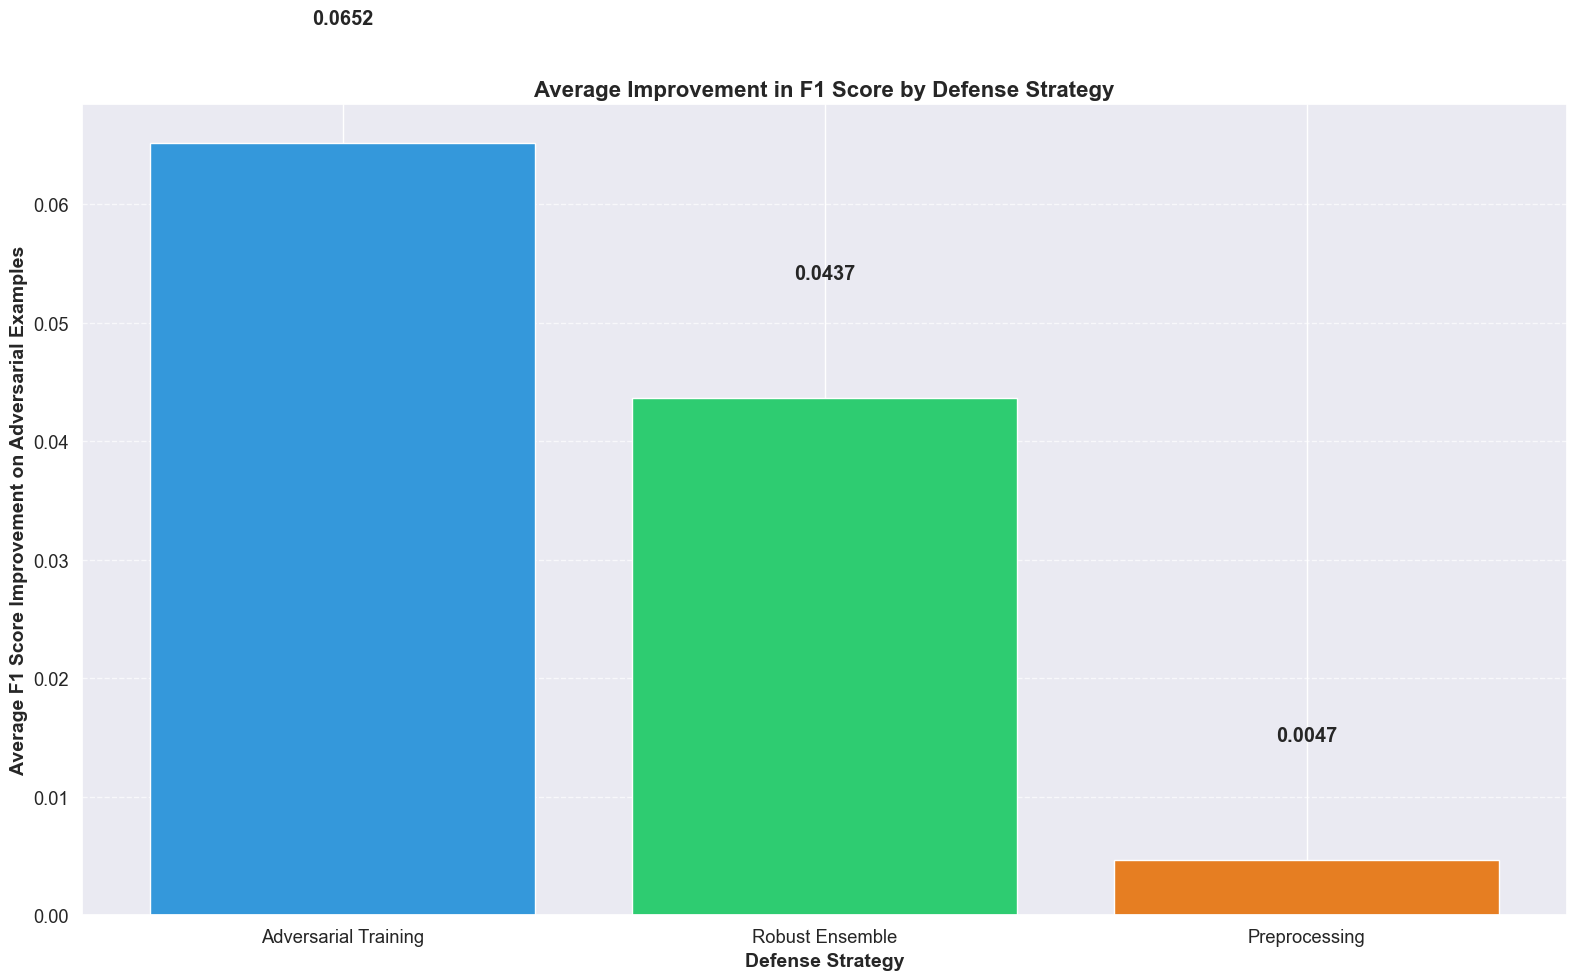

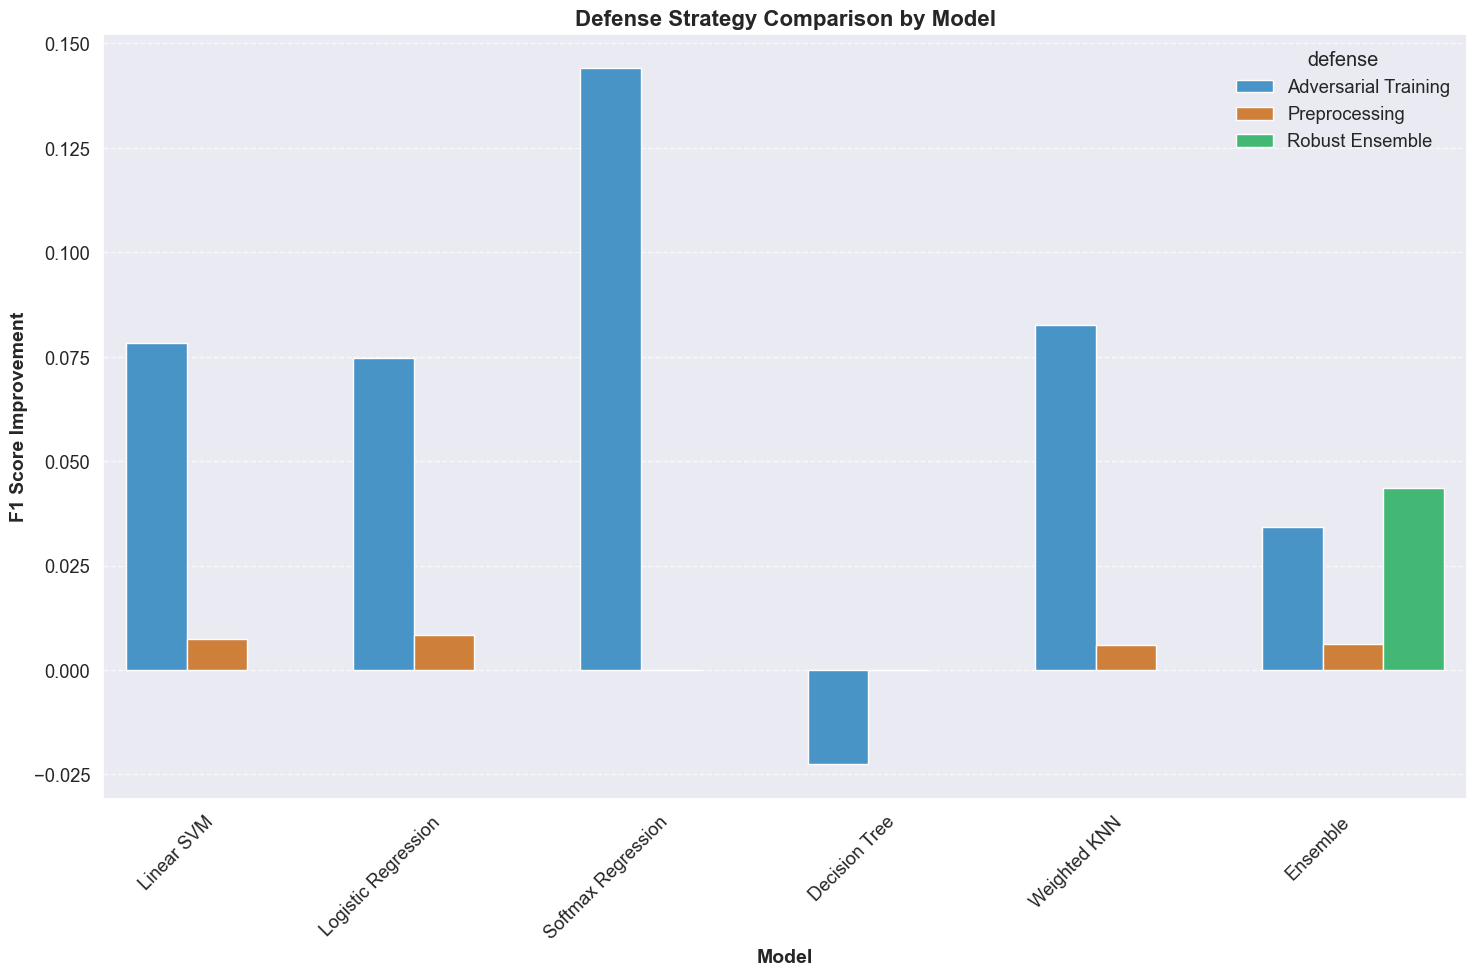

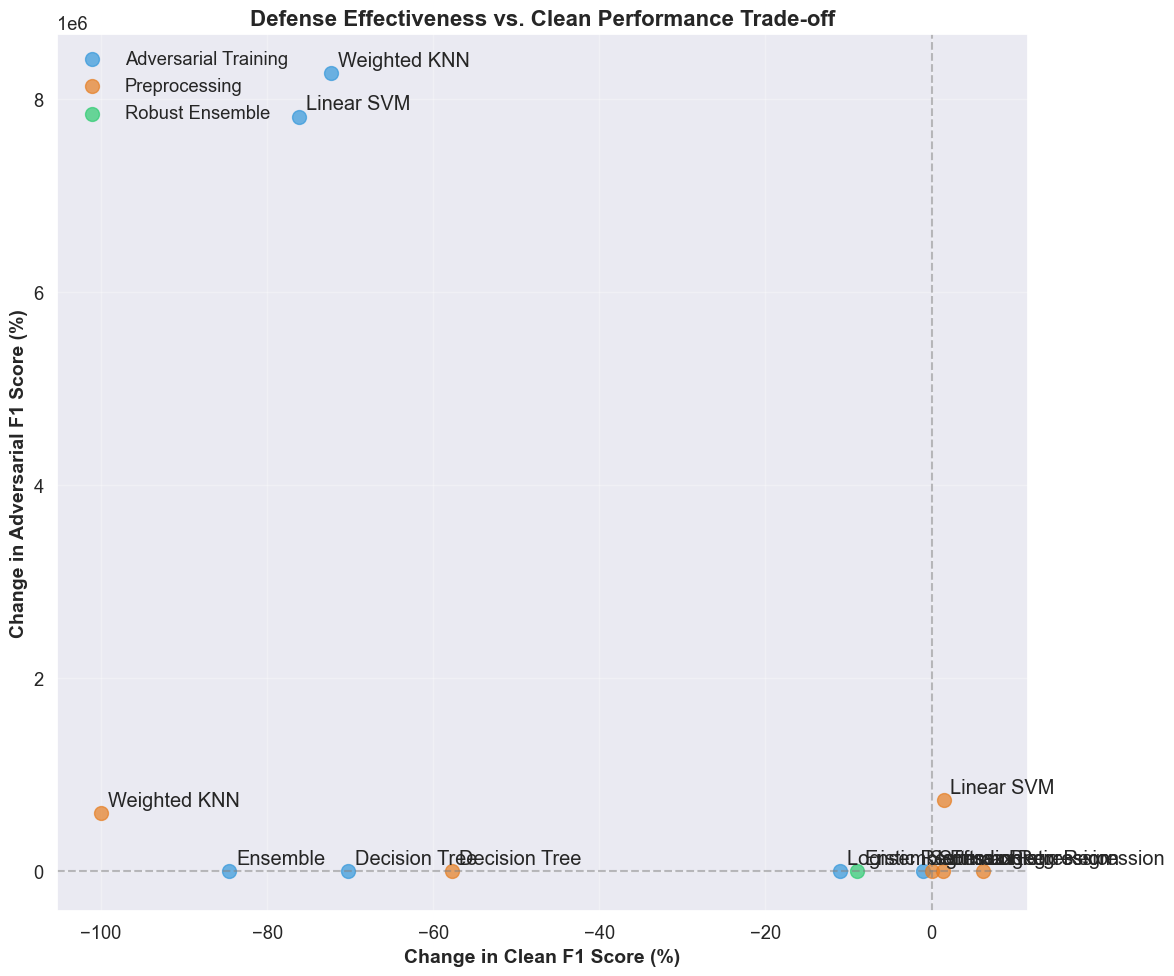

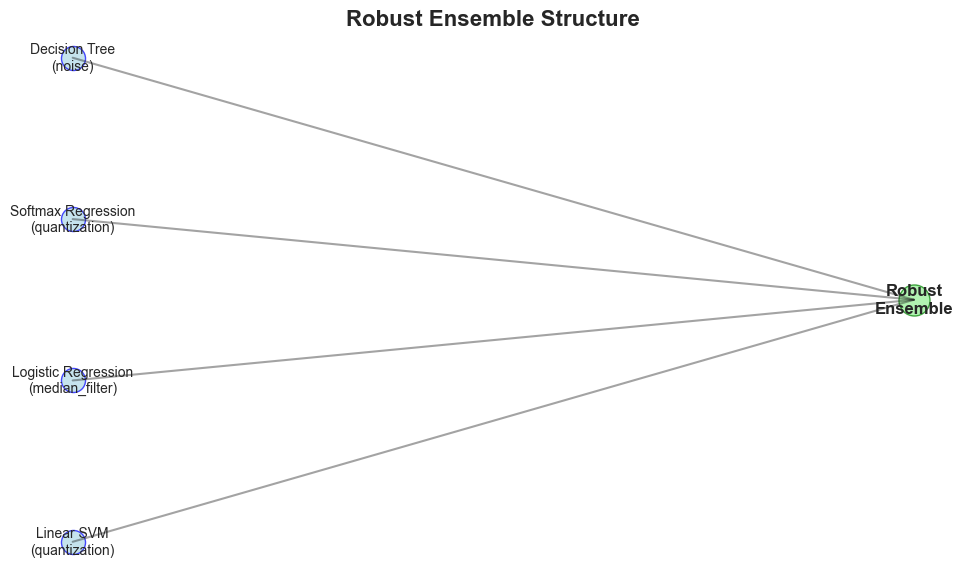

All visualizations have been saved to the 'robust_ensemble_plots' directory.

Final Defense Strategy Comparison:
    Defense Strategy  Avg Improvement  Max Improvement  Avg Clean F1  Avg Adv F1
Adversarial Training           0.0652           0.1440        0.0805      0.1380
       Preprocessing           0.0047           0.0084        0.2003      0.1064
     Robust Ensemble           0.0437           0.0437        0.3578      0.1189

Best Overall Defense Configuration:
  Strategy: Adversarial Training
  Model: Softmax Regression
  Clean F1: 0.0549
  Adversarial F1: 0.2425
  Improvement: 0.1440


In [55]:
# Create directory for ensemble plots
ensemble_plot_dir = "robust_ensemble_plots"
if not os.path.exists(ensemble_plot_dir):
    os.makedirs(ensemble_plot_dir)
    print(f"Created directory: {ensemble_plot_dir}")

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# 1. Compare all defense strategies
print("\nComparing all defense strategies...")

# Collect results from all defense strategies
defense_comparison = []

# Add adversarial training results
if 'adv_training_df' in globals():
    for _, row in adv_training_df.iterrows():
        defense_comparison.append({
            'model': row['model'],
            'defense': 'Adversarial Training',
            'orig_clean_f1': row['orig_clean_f1'],
            'orig_adv_f1': row['orig_adv_f1'],
            'robust_clean_f1': row['robust_clean_f1'],
            'robust_adv_f1': row['robust_adv_f1'],
            'improvement': row['robust_adv_f1'] - row['orig_adv_f1']
        })

# Add preprocessing results (best configuration for each model)
if 'best_configs_df' in globals():
    for _, row in best_configs_df.iterrows():
        defense_comparison.append({
            'model': row['model'],
            'defense': 'Preprocessing',
            'defense_type': row['defense_type'],
            'orig_clean_f1': row['orig_clean_f1'],
            'orig_adv_f1': row['orig_adv_f1'],
            'robust_clean_f1': row['robust_clean_f1'],
            'robust_adv_f1': row['robust_adv_f1'],
            'improvement': row['robust_adv_f1'] - row['orig_adv_f1']
        })

# Add robust ensemble results
defense_comparison.append({
    'model': 'Ensemble',
    'defense': 'Robust Ensemble',
    'orig_clean_f1': metrics['orig_clean_f1'],
    'orig_adv_f1': metrics['orig_adv_f1'],
    'robust_clean_f1': metrics['robust_clean_f1'],
    'robust_adv_f1': metrics['robust_adv_f1'],
    'improvement': metrics['robust_adv_f1'] - metrics['orig_adv_f1']
})

# Convert to DataFrame for easier analysis
defense_comparison_df = pd.DataFrame(defense_comparison)

# Save comparison results
comparison_path = "defense_strategy_comparison.csv"
defense_comparison_df.to_csv(comparison_path, index=False)
print(f"Comparison results saved to {comparison_path}")

# Create visualization comparing defense strategies
plt.figure(figsize=(16, 10))

# Group by defense type
defense_types = defense_comparison_df['defense'].unique()
colors = {'Adversarial Training': '#3498db', 'Preprocessing': '#e67e22', 'Robust Ensemble': '#2ecc71'}

# Calculate mean improvement by defense type
defense_means = []
for defense in defense_types:
    defense_data = defense_comparison_df[defense_comparison_df['defense'] == defense]
    avg_improvement = defense_data['improvement'].mean()
    defense_means.append({'defense': defense, 'avg_improvement': avg_improvement})

defense_means_df = pd.DataFrame(defense_means).sort_values(by='avg_improvement', ascending=False)

# Plot bar chart of average improvement by defense type
bars = plt.bar(defense_means_df['defense'], defense_means_df['avg_improvement'], 
               color=[colors[d] for d in defense_means_df['defense']])

# Add data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.4f}', ha='center', fontweight='bold')

plt.title('Average Improvement in F1 Score by Defense Strategy', fontsize=16, fontweight='bold')
plt.xlabel('Defense Strategy', fontsize=14, fontweight='bold')
plt.ylabel('Average F1 Score Improvement on Adversarial Examples', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"{ensemble_plot_dir}/defense_strategy_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. Compare defense strategies by model
plt.figure(figsize=(15, 10))

# Only include models that have results for both adversarial training and preprocessing
common_models = list(set(defense_comparison_df[defense_comparison_df['defense'] == 'Adversarial Training']['model']) & 
                    set(defense_comparison_df[defense_comparison_df['defense'] == 'Preprocessing']['model']))

# Filter to common models
filtered_df = defense_comparison_df[
    (defense_comparison_df['model'].isin(common_models)) | 
    (defense_comparison_df['defense'] == 'Robust Ensemble')
]

# Plot
sns.barplot(x='model', y='improvement', hue='defense', data=filtered_df, palette=colors)
plt.title('Defense Strategy Comparison by Model', fontsize=16, fontweight='bold')
plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.ylabel('F1 Score Improvement', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"{ensemble_plot_dir}/defense_by_model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. Show defense effectiveness vs. clean performance tradeoff
plt.figure(figsize=(12, 10))

# Calculate relative changes
filtered_df['clean_performance_ratio'] = filtered_df['robust_clean_f1'] / filtered_df['orig_clean_f1']
filtered_df['adv_performance_ratio'] = filtered_df['robust_adv_f1'] / filtered_df['orig_adv_f1'].replace(0, 1e-6)

# Convert to percentage change
filtered_df['clean_perf_change'] = (filtered_df['clean_performance_ratio'] - 1) * 100
filtered_df['adv_perf_change'] = (filtered_df['adv_performance_ratio'] - 1) * 100

# Create scatter plot
for defense in defense_types:
    defense_data = filtered_df[filtered_df['defense'] == defense]
    plt.scatter(defense_data['clean_perf_change'], defense_data['adv_perf_change'], 
               label=defense, color=colors[defense], s=100, alpha=0.7)
    
    # Add model name annotations
    for _, row in defense_data.iterrows():
        plt.annotate(row['model'], 
                    (row['clean_perf_change'], row['adv_perf_change']),
                    xytext=(5, 5), textcoords='offset points')

# Add quadrant lines
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

plt.title('Defense Effectiveness vs. Clean Performance Trade-off', fontsize=16, fontweight='bold')
plt.xlabel('Change in Clean F1 Score (%)', fontsize=14, fontweight='bold')
plt.ylabel('Change in Adversarial F1 Score (%)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(f"{ensemble_plot_dir}/defense_effectiveness_tradeoff.png", dpi=300, bbox_inches='tight')
plt.show()

# 4. Compare against different attacks - if we had results for different attack types
if 'robust_ensemble' in locals():
    # Create a special plot showing robust ensemble performance
    plt.figure(figsize=(10, 6))
    
    # Show robust ensemble internal structure
    ax = plt.subplot(111)
    
    # Create visual representation of the ensemble
    defense_types_used = [model_name + f"\n({defensive_models[model_name].preprocessor.defense_type})" 
                         for model_name in defensive_models.keys()]
    
    # Create a tree-like structure
    plt.scatter([1, 1, 1, 1], [1, 2, 3, 4], s=300, color='lightblue', edgecolors='blue', alpha=0.7)
    plt.scatter([2], [2.5], s=500, color='lightgreen', edgecolors='green', alpha=0.7)
    
    # Add connecting lines
    for i in range(4):
        plt.plot([1, 2], [i+1, 2.5], 'k-', alpha=0.4)
    
    # Add labels
    for i, name in enumerate(defense_types_used):
        plt.text(1, i+1, name, ha='center', va='center', fontsize=10)
    
    plt.text(2, 2.5, 'Robust\nEnsemble', ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Remove axes
    plt.axis('off')
    plt.title('Robust Ensemble Structure', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{ensemble_plot_dir}/robust_ensemble_structure.png", dpi=300, bbox_inches='tight')
    plt.show()

print(f"All visualizations have been saved to the '{ensemble_plot_dir}' directory.")

# Final summary of all defense strategies
print("\nFinal Defense Strategy Comparison:")
summary_df = defense_comparison_df.groupby('defense').agg({
    'improvement': ['mean', 'max'],
    'robust_clean_f1': 'mean',
    'robust_adv_f1': 'mean'
}).reset_index()

# Format the summary
summary_df.columns = ['Defense Strategy', 'Avg Improvement', 'Max Improvement', 'Avg Clean F1', 'Avg Adv F1']
print(summary_df.to_string(index=False, float_format="%.4f"))

# Get the best overall defense
best_defense = defense_comparison_df.loc[defense_comparison_df['robust_adv_f1'].idxmax()]
print(f"\nBest Overall Defense Configuration:")
print(f"  Strategy: {best_defense['defense']}")
print(f"  Model: {best_defense['model']}")
print(f"  Clean F1: {best_defense['robust_clean_f1']:.4f}")
print(f"  Adversarial F1: {best_defense['robust_adv_f1']:.4f}")
print(f"  Improvement: {best_defense['improvement']:.4f}")

#### Adversarial Detection

In [58]:
print("\n" + "="*70)
print("IMPLEMENTING ADVERSARIAL DETECTION DEFENSE")
print("="*70)

# Improved parameters for adversarial detection
detection_params = {
    'threshold_percentile': 90,      # Lower percentile for more sensitive detection (was 95)
    'rejection_threshold': 0.5,      # Lower threshold to increase detection sensitivity (was 0.6)
    'fallback_strategy': 'most_common',  # Strategy for handling detected adversarial examples
    'sample_size': 50,               # Number of samples to use in evaluation
    'training_samples': 300          # Increased training samples (was 200)
}

print(f"Detection parameters: threshold_percentile={detection_params['threshold_percentile']}, "
      f"rejection_threshold={detection_params['rejection_threshold']}, "
      f"fallback_strategy={detection_params['fallback_strategy']}")

# Create directory for saving detection models
if not os.path.exists('detection_defense_models'):
    os.makedirs('detection_defense_models')
    print(f"Created directory: detection_defense_models")

# List to collect results
detection_results = []

# Process each model (excluding Ensemble)
for model_name, base_model in all_models.items():
    # Skip Ensemble model due to pickling issues
    if model_name == 'Ensemble':
        continue
        
    print(f"\n{'-'*50}")
    print(f"Processing {model_name}...")
    
    try:
        # Select appropriate features based on model
        if model_name != 'Weighted KNN':
            train_subset = X_test_scaled[:detection_params['training_samples']]  # Use subset of test set for training detector
            test_features = X_test_scaled
        else:
            train_subset = X_test_reduced[:detection_params['training_samples']]
            test_features = X_test_reduced
        
        # Time the process
        start_time = time.time()
        
        # Create adversarial detector
        print(f"Creating adversarial detector for {model_name}...")
        detector = AdversarialDetector(
            base_model, 
            train_subset, 
            threshold_percentile=detection_params['threshold_percentile']
        )
        
        # Create defensive wrapper with the detector
        robust_model = DetectorDefensiveWrapper(
            base_model,
            detector,
            rejection_threshold=detection_params['rejection_threshold'],
            fallback_strategy=detection_params['fallback_strategy']
        )
        
        # Set class frequencies for fallback strategy if using most_common
        if detection_params['fallback_strategy'] == 'most_common':
            robust_model.set_class_frequencies(test_labels[:detection_params['training_samples']])
        
        # Save the detector
        detector_path = f"detection_defense_models/detector_{model_name.replace(' ', '_').lower()}.pkl"
        joblib.dump(detector, detector_path)
        print(f"Saved detector to {detector_path}")
        
        # Measure time
        detection_setup_time = time.time() - start_time
        
        # Evaluate defense effectiveness
        print(f"Evaluating effectiveness...")
        metrics = evaluate_defense(
            defense_name=f"Adversarial Detection - {model_name}",
            original_model=base_model,
            robust_model=robust_model,
            X_test=test_features,
            y_test=test_labels,
            attack_func=attack_func,
            epsilon=0.2,  # Using consistent attack strength
            sample_size=detection_params['sample_size']
        )
        
        # Add model name, defense type, and processing time to metrics
        metrics['model'] = model_name
        metrics['defense_type'] = 'detection'
        metrics['threshold_percentile'] = detection_params['threshold_percentile']
        metrics['rejection_threshold'] = detection_params['rejection_threshold']
        metrics['fallback_strategy'] = detection_params['fallback_strategy']
        metrics['setup_time'] = detection_setup_time
        
        # Add to results
        detection_results.append(metrics)
        
        # Print key metrics
        print(f"Original model F1 on adversarial examples: {metrics['orig_adv_f1']:.4f}")
        print(f"Robust model F1 on adversarial examples: {metrics['robust_adv_f1']:.4f}")
        print(f"Improvement: {metrics['robust_adv_f1'] - metrics['orig_adv_f1']:.4f}")
        
    except Exception as e:
        print(f"Error processing {model_name}: {str(e)}")
        traceback.print_exc()

# Handle ensemble model separately using in-memory detection (no saving)
print(f"\n{'-'*50}")
print(f"Processing Ensemble (special handling)...")
model_name = 'Ensemble'
base_model = all_models[model_name]

try:
    # Time the process
    start_time = time.time()
    
    # Create detector but don't save it
    print("Creating detector for Ensemble model (memory only, not saved)...")
    detector = AdversarialDetector(
        base_model, 
        X_test_scaled[:detection_params['training_samples']], 
        threshold_percentile=detection_params['threshold_percentile']
    )
    
    # Create defensive wrapper
    robust_model = DetectorDefensiveWrapper(
        base_model,
        detector,
        rejection_threshold=detection_params['rejection_threshold'],
        fallback_strategy=detection_params['fallback_strategy']
    )
    
    # Set class frequencies
    robust_model.set_class_frequencies(test_labels[:detection_params['training_samples']])
    
    # Don't save detector - skip this step
    print("Skipping save step for Ensemble detector to avoid pickle errors")
    
    # Measure time
    detection_setup_time = time.time() - start_time
    
    # Evaluate effectiveness
    metrics = evaluate_defense(
        defense_name=f"Adversarial Detection - {model_name}",
        original_model=base_model,
        robust_model=robust_model,
        X_test=X_test_scaled,
        y_test=test_labels,
        attack_func=attack_func,
        epsilon=0.2,  # Using consistent attack strength
        sample_size=detection_params['sample_size']
    )
    
    # Add model name, defense type, and processing time to metrics
    metrics['model'] = model_name
    metrics['defense_type'] = 'detection'
    metrics['threshold_percentile'] = detection_params['threshold_percentile']
    metrics['rejection_threshold'] = detection_params['rejection_threshold']
    metrics['fallback_strategy'] = detection_params['fallback_strategy']
    metrics['setup_time'] = detection_setup_time
    
    # Add to results
    detection_results.append(metrics)
    
    # Print key metrics
    print(f"Original ensemble F1 on adversarial examples: {metrics['orig_adv_f1']:.4f}")
    print(f"Robust ensemble F1 on adversarial examples: {metrics['robust_adv_f1']:.4f}")
    print(f"Improvement: {metrics['robust_adv_f1'] - metrics['orig_adv_f1']:.4f}")
    
except Exception as e:
    print(f"Error processing {model_name}: {str(e)}")
    traceback.print_exc()

# Convert results to DataFrame
detection_df = pd.DataFrame(detection_results)

# Save results to CSV
csv_path = "detection_defense_results.csv"
detection_df.to_csv(csv_path, index=False)
print(f"\nResults saved to {csv_path}")

# Display summary table
print("\nAdversarial Detection Defense Summary:")
summary_columns = ['model', 'orig_clean_f1', 'orig_adv_f1', 'robust_clean_f1', 'robust_adv_f1', 
                  'setup_time']
summary_df = detection_df[summary_columns].sort_values(by=['robust_adv_f1'], ascending=False)
print(summary_df.to_string(index=False))


IMPLEMENTING ADVERSARIAL DETECTION DEFENSE
Detection parameters: threshold_percentile=90, rejection_threshold=0.5, fallback_strategy=most_common

--------------------------------------------------
Processing Linear SVM...
Creating adversarial detector for Linear SVM...
Saved detector to detection_defense_models/detector_linear_svm.pkl
Evaluating effectiveness...
Original model F1 on adversarial examples: 0.0187
Robust model F1 on adversarial examples: 0.0187
Improvement: 0.0000

--------------------------------------------------
Processing Logistic Regression...
Creating adversarial detector for Logistic Regression...
Saved detector to detection_defense_models/detector_logistic_regression.pkl
Evaluating effectiveness...
Original model F1 on adversarial examples: 0.1606
Robust model F1 on adversarial examples: 0.1606
Improvement: 0.0000

--------------------------------------------------
Processing Softmax Regression...
Creating adversarial detector for Softmax Regression...
Saved dete

Created directory: detection_defense_plots


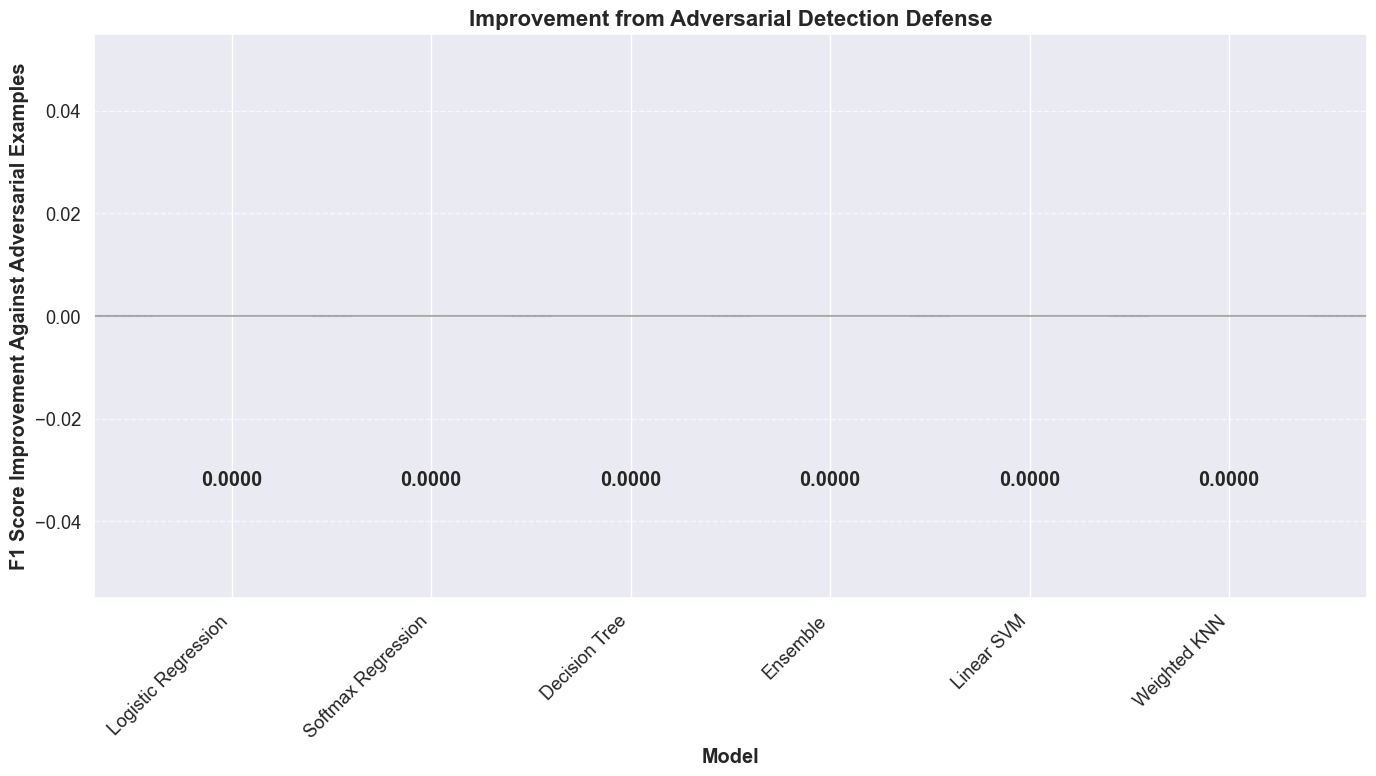

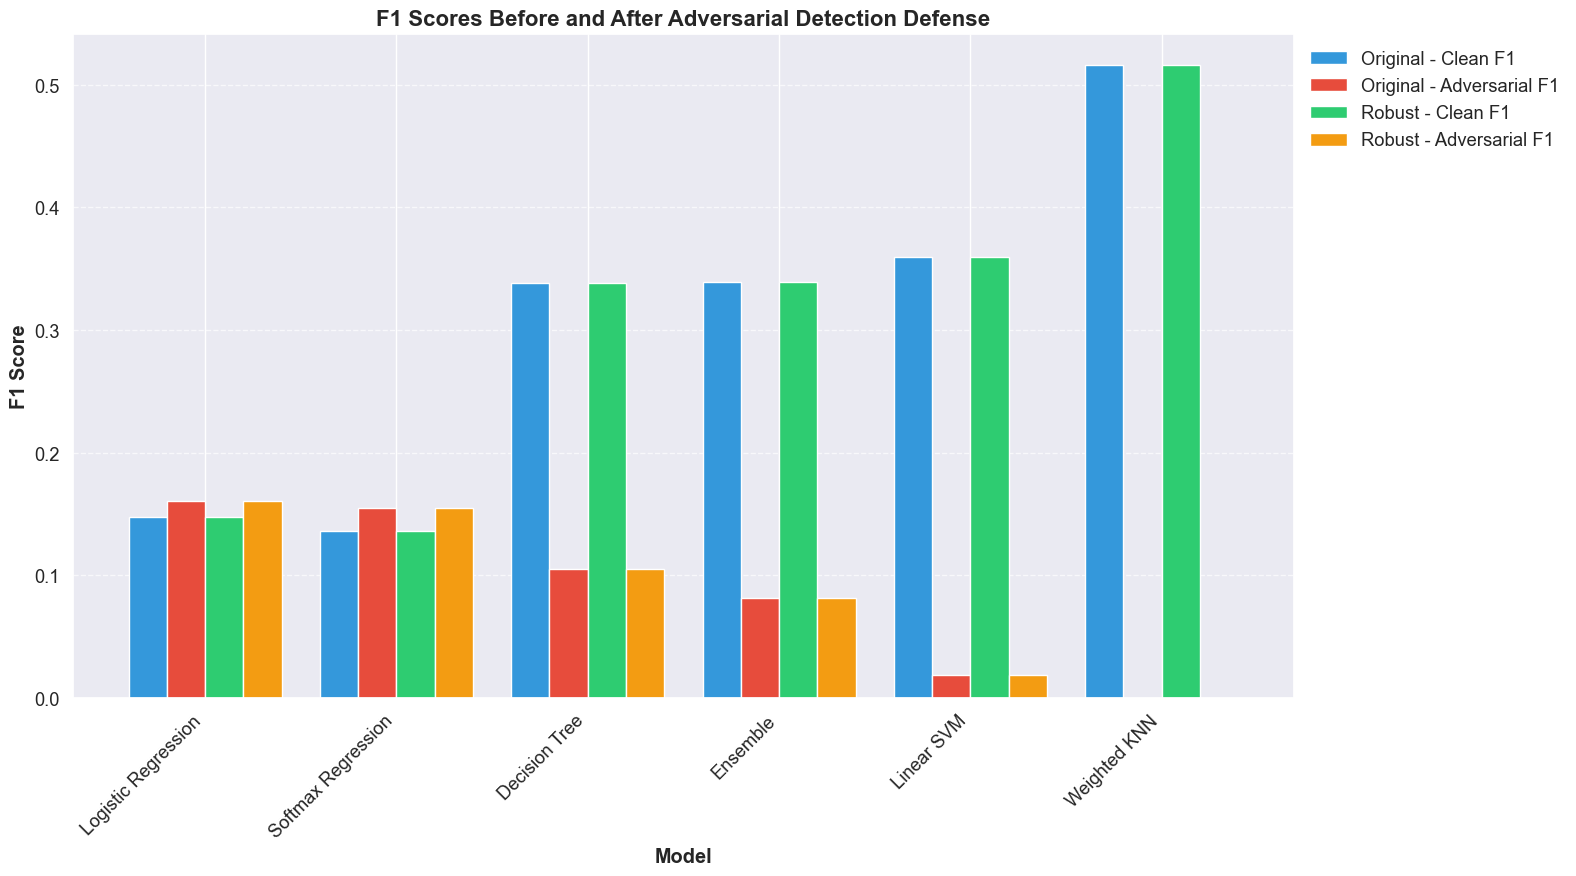

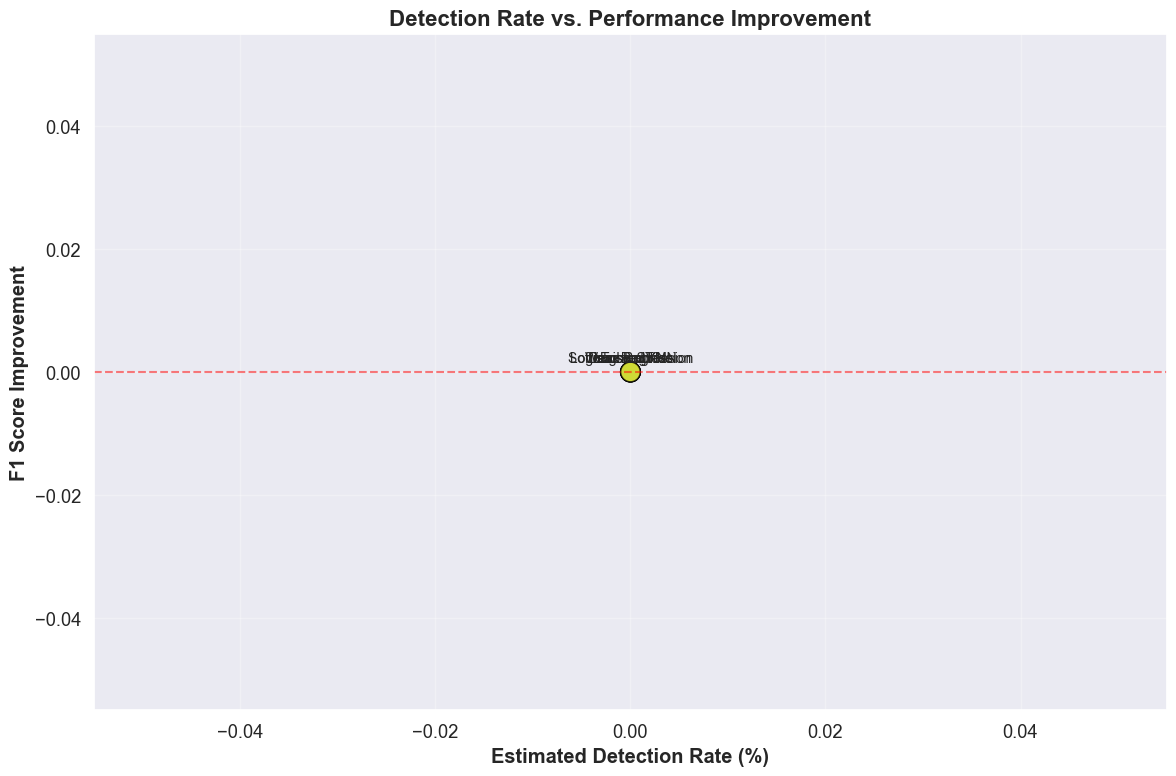

<Figure size 1600x800 with 0 Axes>

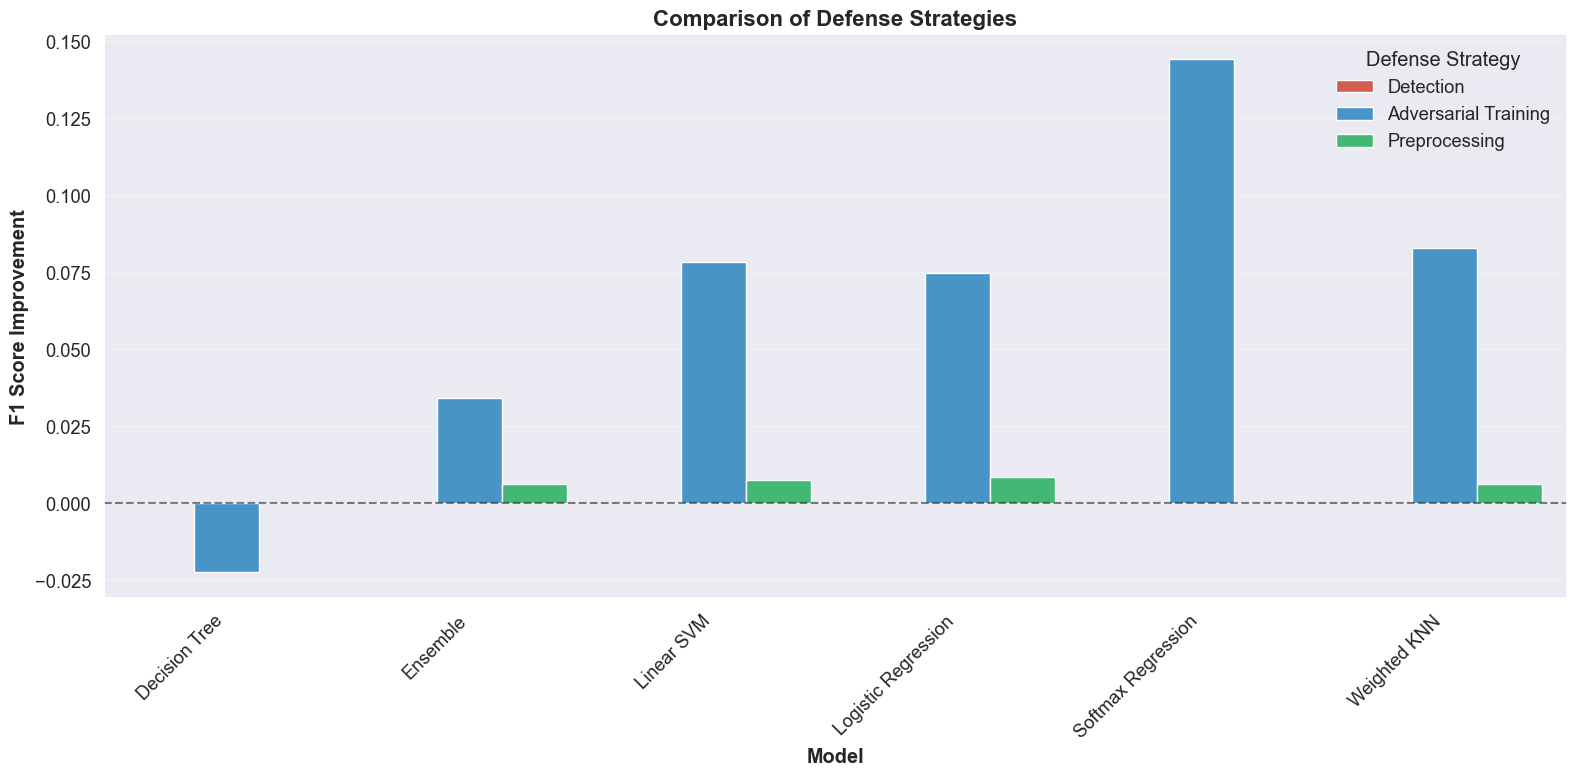

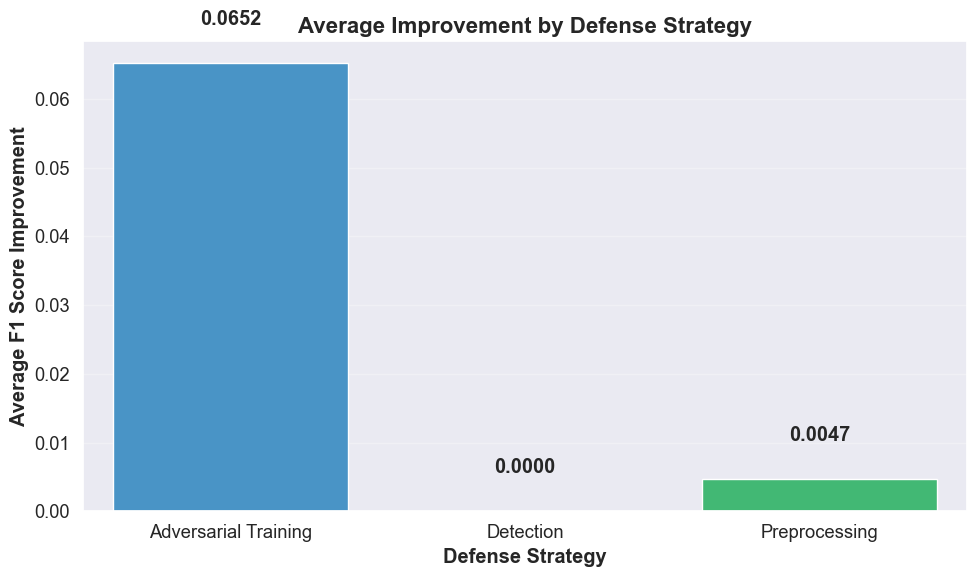

All detection defense visualizations have been saved to the 'detection_defense_plots' directory.


In [59]:
# Create directory for detection plots
detection_plot_dir = "detection_defense_plots"
if not os.path.exists(detection_plot_dir):
    os.makedirs(detection_plot_dir)
    print(f"Created directory: {detection_plot_dir}")

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# Sort models by performance
model_order = detection_df.sort_values(by=['robust_adv_f1'], ascending=False)['model'].values

# 1. Effectiveness of Detection Defense
plt.figure(figsize=(14, 8))

# Calculate effectiveness metrics
improvements = []
detection_rate = []

for model in model_order:
    model_data = detection_df[detection_df['model'] == model]
    imp = model_data['robust_adv_f1'].values[0] - model_data['orig_adv_f1'].values[0]
    improvements.append(imp)
    # Calculate approximate detection rate (based on clean vs robust F1 difference)
    clean_diff = abs(model_data['robust_clean_f1'].values[0] - model_data['orig_clean_f1'].values[0])
    detection_rate.append(clean_diff * 100)  # Convert to percentage

# Create bars with color based on improvement value
colors = ['#2ecc71' if imp > 0 else '#e74c3c' for imp in improvements]
plt.bar(model_order, improvements, color=colors)

# Add horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add value labels on top of each bar
for i, imp in enumerate(improvements):
    plt.text(i, imp + (0.01 if imp > 0 else -0.03), 
             f"{imp:.4f}", ha='center', va='bottom' if imp > 0 else 'top',
             fontweight='bold')

plt.xlabel('Model', fontweight='bold')
plt.ylabel('F1 Score Improvement Against Adversarial Examples', fontweight='bold')
plt.title('Improvement from Adversarial Detection Defense', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"{detection_plot_dir}/detection_improvement.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. Comparing clean and adversarial performance
plt.figure(figsize=(16, 9))
bar_width = 0.2
x = np.arange(len(model_order))

# Get data for each category
clean_f1_orig = [detection_df[detection_df['model'] == model]['orig_clean_f1'].values[0] for model in model_order]
adv_f1_orig = [detection_df[detection_df['model'] == model]['orig_adv_f1'].values[0] for model in model_order]
clean_f1_robust = [detection_df[detection_df['model'] == model]['robust_clean_f1'].values[0] for model in model_order]
adv_f1_robust = [detection_df[detection_df['model'] == model]['robust_adv_f1'].values[0] for model in model_order]

# Plot bars
plt.bar(x - 1.5*bar_width, clean_f1_orig, bar_width, label='Original - Clean F1', color='#3498db')
plt.bar(x - 0.5*bar_width, adv_f1_orig, bar_width, label='Original - Adversarial F1', color='#e74c3c')
plt.bar(x + 0.5*bar_width, clean_f1_robust, bar_width, label='Robust - Clean F1', color='#2ecc71')
plt.bar(x + 1.5*bar_width, adv_f1_robust, bar_width, label='Robust - Adversarial F1', color='#f39c12')

# Add labels and legend
plt.xlabel('Model', fontweight='bold')
plt.ylabel('F1 Score', fontweight='bold')
plt.title('F1 Scores Before and After Adversarial Detection Defense', fontsize=16, fontweight='bold')
plt.xticks(x, model_order, rotation=45, ha='right')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"{detection_plot_dir}/f1_score_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. Estimated detection rate vs improvement
plt.figure(figsize=(12, 8))

plt.scatter(detection_rate, improvements, s=200, alpha=0.7, 
           c=range(len(model_order)), cmap='viridis', edgecolors='black')

# Add model names as annotations
for i, model in enumerate(model_order):
    plt.annotate(model, (detection_rate[i], improvements[i]), 
                fontsize=10, ha='center', va='bottom', 
                xytext=(0, 5), textcoords='offset points')

plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)  # Line at y=0 for reference

plt.xlabel('Estimated Detection Rate (%)', fontweight='bold')
plt.ylabel('F1 Score Improvement', fontweight='bold')
plt.title('Detection Rate vs. Performance Improvement', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{detection_plot_dir}/detection_rate_vs_improvement.png", dpi=300, bbox_inches='tight')
plt.show()

# 4. Compare with other defense strategies
if 'adv_training_df' in globals() and 'best_configs_df' in globals():
    plt.figure(figsize=(16, 8))
    
    # Get common models across all defense types
    common_models = list(set(detection_df['model']) & 
                        set(adv_training_df['model']) &
                        set(best_configs_df['model']))
    common_models.sort()
    
    if len(common_models) > 0:
        # Create comparison data
        comparison_data = []
        
        # Add adversarial detection data
        for model in common_models:
            model_data = detection_df[detection_df['model'] == model]
            comparison_data.append({
                'model': model,
                'defense': 'Detection',
                'orig_adv_f1': model_data['orig_adv_f1'].values[0],
                'robust_adv_f1': model_data['robust_adv_f1'].values[0],
                'improvement': model_data['robust_adv_f1'].values[0] - model_data['orig_adv_f1'].values[0]
            })
        
        # Add adversarial training data
        for model in common_models:
            model_data = adv_training_df[adv_training_df['model'] == model]
            comparison_data.append({
                'model': model,
                'defense': 'Adversarial Training',
                'orig_adv_f1': model_data['orig_adv_f1'].values[0],
                'robust_adv_f1': model_data['robust_adv_f1'].values[0],
                'improvement': model_data['robust_adv_f1'].values[0] - model_data['orig_adv_f1'].values[0]
            })
            
        # Add preprocessing data
        for model in common_models:
            model_data = best_configs_df[best_configs_df['model'] == model]
            comparison_data.append({
                'model': model,
                'defense': 'Preprocessing',
                'orig_adv_f1': model_data['orig_adv_f1'].values[0],
                'robust_adv_f1': model_data['robust_adv_f1'].values[0],
                'improvement': model_data['robust_adv_f1'].values[0] - model_data['orig_adv_f1'].values[0]
            })
        
        # Create DataFrame
        comparison_df = pd.DataFrame(comparison_data)
        
        # Plot comparison
        plt.figure(figsize=(16, 8))
        sns.barplot(x='model', y='improvement', hue='defense', data=comparison_df, 
                   palette={'Detection': '#e74c3c', 'Adversarial Training': '#3498db', 'Preprocessing': '#2ecc71'})
        
        plt.title('Comparison of Defense Strategies', fontsize=16, fontweight='bold')
        plt.xlabel('Model', fontweight='bold')
        plt.ylabel('F1 Score Improvement', fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        plt.legend(title='Defense Strategy')
        plt.tight_layout()
        plt.savefig(f"{detection_plot_dir}/defense_comparison.png", dpi=300, bbox_inches='tight')
        plt.show()

        # Calculate and display average improvement by strategy
        avg_by_defense = comparison_df.groupby('defense')['improvement'].mean().reset_index()
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='defense', y='improvement', data=avg_by_defense, 
                   palette={'Detection': '#e74c3c', 'Adversarial Training': '#3498db', 'Preprocessing': '#2ecc71'})
        
        # Add value labels
        for i, row in avg_by_defense.iterrows():
            plt.text(i, row['improvement'] + 0.005, f"{row['improvement']:.4f}", 
                    ha='center', va='bottom', fontweight='bold')
        
        plt.title('Average Improvement by Defense Strategy', fontsize=16, fontweight='bold')
        plt.xlabel('Defense Strategy', fontweight='bold')
        plt.ylabel('Average F1 Score Improvement', fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"{detection_plot_dir}/avg_improvement_by_strategy.png", dpi=300, bbox_inches='tight')
        plt.show()

print(f"All detection defense visualizations have been saved to the '{detection_plot_dir}' directory.")

All defense strategies comparison saved to all_defense_strategies_comparison.csv


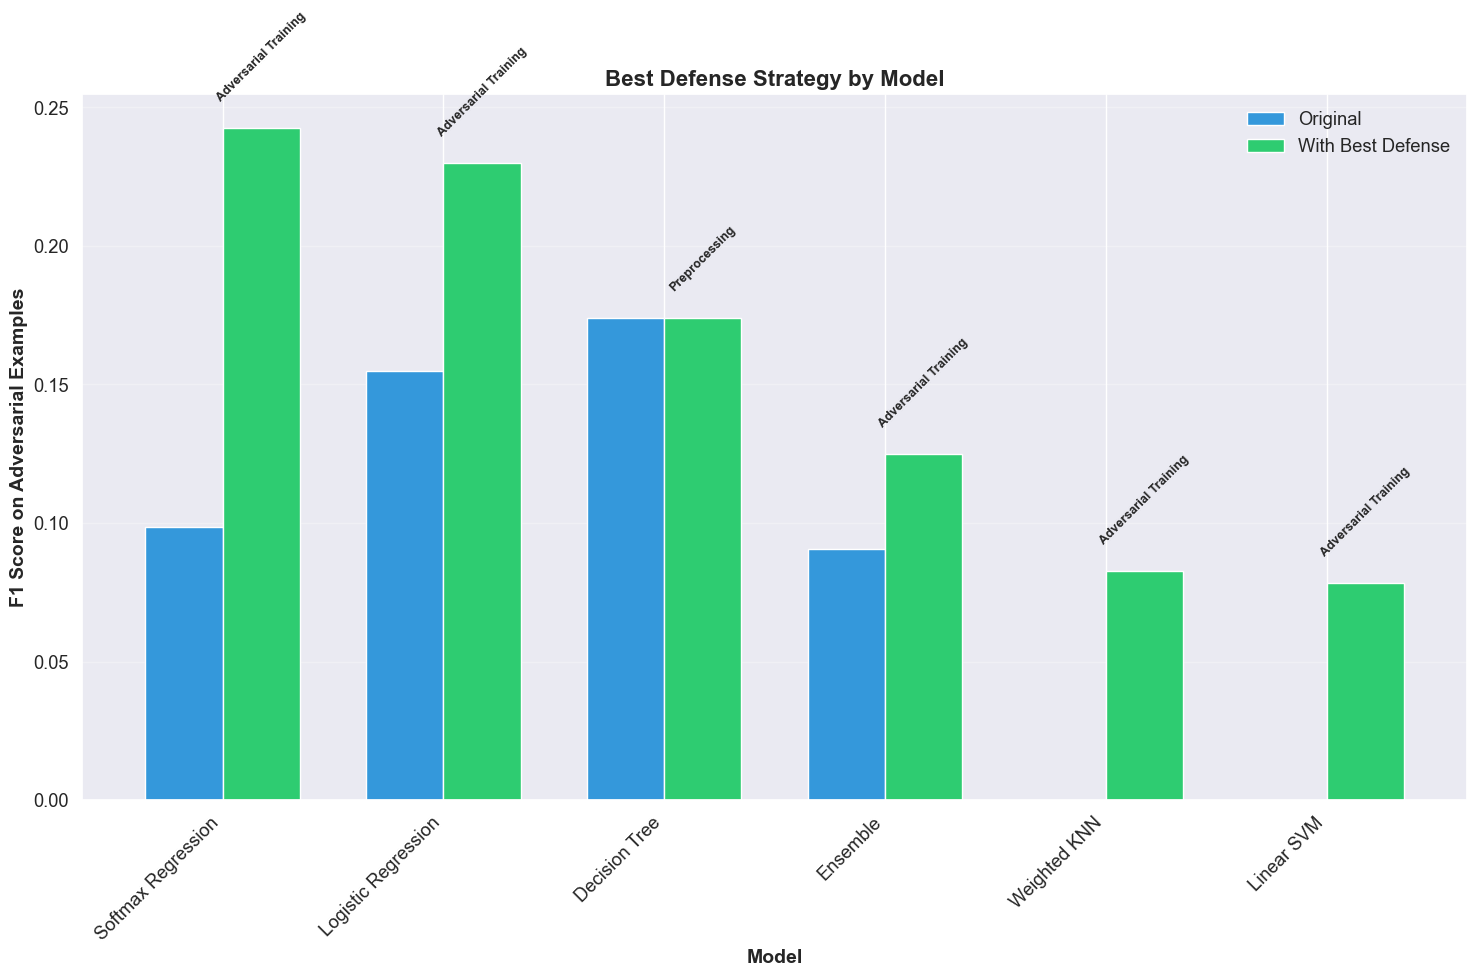

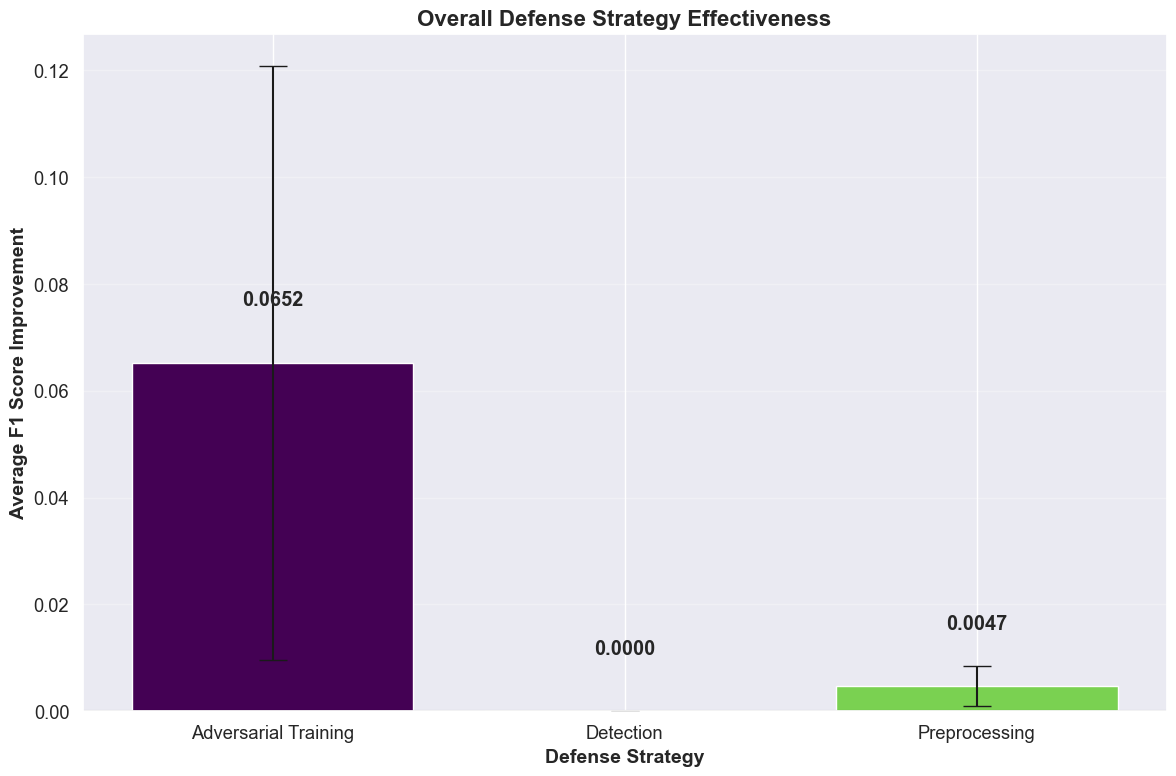

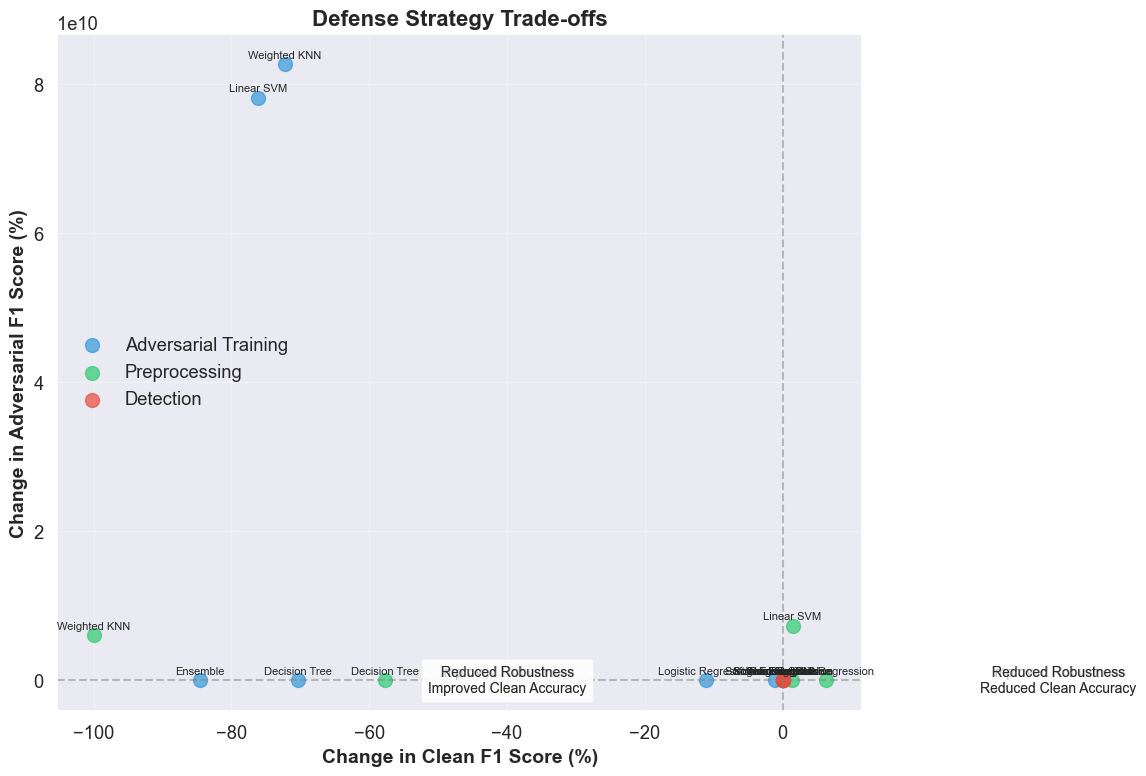


Final Defense Strategy Comparison:
              model              defense          defense_detail  orig_clean_f1  orig_adv_f1  robust_clean_f1  robust_adv_f1  improvement
 Softmax Regression Adversarial Training            Adv Training       0.055495     0.098522         0.054906       0.242537     0.144015
       Weighted KNN Adversarial Training            Adv Training       0.523457     0.000000         0.145161       0.082645     0.082645
         Linear SVM Adversarial Training            Adv Training       0.287356     0.000000         0.068558       0.078174     0.078174
Logistic Regression Adversarial Training            Adv Training       0.071736     0.154930         0.063803       0.229730     0.074800
           Ensemble Adversarial Training            Adv Training       0.388350     0.090592         0.059884       0.124722     0.034129
Logistic Regression        Preprocessing Preproc (median_filter)       0.129246     0.157617         0.137311       0.166052     0.00843

In [60]:
# Create directory for final comparison plots
final_plot_dir = "defense_comparison_plots"
if not os.path.exists(final_plot_dir):
    os.makedirs(final_plot_dir)
    print(f"Created directory: {final_plot_dir}")

# Collect data from all defense strategies
all_defense_results = []

# 1. Add adversarial training results
if 'adv_training_df' in globals():
    for _, row in adv_training_df.iterrows():
        all_defense_results.append({
            'model': row['model'],
            'defense': 'Adversarial Training',
            'defense_detail': 'Adv Training',
            'orig_clean_f1': row['orig_clean_f1'],
            'orig_adv_f1': row['orig_adv_f1'],
            'robust_clean_f1': row['robust_clean_f1'],
            'robust_adv_f1': row['robust_adv_f1'],
            'improvement': row['robust_adv_f1'] - row['orig_adv_f1']
        })

# 2. Add best preprocessing results
if 'best_configs_df' in globals():
    for _, row in best_configs_df.iterrows():
        all_defense_results.append({
            'model': row['model'],
            'defense': 'Preprocessing',
            'defense_detail': f"Preproc ({row['defense_type']})",
            'orig_clean_f1': row['orig_clean_f1'],
            'orig_adv_f1': row['orig_adv_f1'],
            'robust_clean_f1': row['robust_clean_f1'],
            'robust_adv_f1': row['robust_adv_f1'],
            'improvement': row['robust_adv_f1'] - row['orig_adv_f1']
        })

# 3. Add adversarial detection results
if 'detection_df' in globals():
    for _, row in detection_df.iterrows():
        all_defense_results.append({
            'model': row['model'],
            'defense': 'Detection',
            'defense_detail': f"Detection (p{row['threshold_percentile']})",
            'orig_clean_f1': row['orig_clean_f1'],
            'orig_adv_f1': row['orig_adv_f1'],
            'robust_clean_f1': row['robust_clean_f1'],
            'robust_adv_f1': row['robust_adv_f1'],
            'improvement': row['robust_adv_f1'] - row['orig_adv_f1']
        })

# Convert to DataFrame
all_defenses_df = pd.DataFrame(all_defense_results)

# Save comparison results
comparison_path = "all_defense_strategies_comparison.csv"
all_defenses_df.to_csv(comparison_path, index=False)
print(f"All defense strategies comparison saved to {comparison_path}")

# Create visualizations

# 1. Best defense by model
plt.figure(figsize=(15, 10))

# For each model, find the best defense
best_by_model = all_defenses_df.loc[all_defenses_df.groupby('model')['robust_adv_f1'].idxmax()]
best_by_model = best_by_model.sort_values('robust_adv_f1', ascending=False)

# Plot
x = np.arange(len(best_by_model))
bar_width = 0.35

# Plot bars
plt.bar(x - bar_width/2, best_by_model['orig_adv_f1'], bar_width, label='Original', color='#3498db')
plt.bar(x + bar_width/2, best_by_model['robust_adv_f1'], bar_width, label='With Best Defense', color='#2ecc71')

# Add defense type as text above each bar
for i, (_, row) in enumerate(best_by_model.iterrows()):
    plt.text(i + bar_width/2, row['robust_adv_f1'] + 0.01, row['defense'], 
            ha='center', rotation=45, fontsize=9, fontweight='bold')

plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.ylabel('F1 Score on Adversarial Examples', fontsize=14, fontweight='bold')
plt.title('Best Defense Strategy by Model', fontsize=16, fontweight='bold')
plt.xticks(x, best_by_model['model'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f"{final_plot_dir}/best_defense_by_model.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. Overall defense effectiveness
plt.figure(figsize=(12, 8))

# Group by defense type
defense_effectiveness = all_defenses_df.groupby('defense').agg({
    'improvement': ['mean', 'max', 'min', 'std'],
    'robust_adv_f1': 'mean',
    'orig_adv_f1': 'mean'
}).reset_index()

# Plot
x = np.arange(len(defense_effectiveness))

# Average improvement by defense type
plt.bar(x, defense_effectiveness['improvement']['mean'], yerr=defense_effectiveness['improvement']['std'],
       capsize=10, color=plt.cm.viridis(np.linspace(0, 0.8, len(defense_effectiveness))))

# Add value labels
for i, val in enumerate(defense_effectiveness['improvement']['mean']):
    plt.text(i, val + (0.01 if val >= 0 else -0.02), 
            f"{val:.4f}", ha='center', va='bottom' if val >= 0 else 'top',
            fontweight='bold')

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Defense Strategy', fontsize=14, fontweight='bold')
plt.ylabel('Average F1 Score Improvement', fontsize=14, fontweight='bold')
plt.title('Overall Defense Strategy Effectiveness', fontsize=16, fontweight='bold')
plt.xticks(x, defense_effectiveness['defense'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f"{final_plot_dir}/defense_effectiveness.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. Trade-off visualization
plt.figure(figsize=(12, 8))

# Calculate trade-offs
all_defenses_df['clean_perf_ratio'] = all_defenses_df['robust_clean_f1'] / all_defenses_df['orig_clean_f1']
all_defenses_df['adv_perf_ratio'] = all_defenses_df['robust_adv_f1'] / (all_defenses_df['orig_adv_f1'] + 1e-10)
all_defenses_df['clean_change'] = (all_defenses_df['clean_perf_ratio'] - 1) * 100
all_defenses_df['adv_change'] = (all_defenses_df['adv_perf_ratio'] - 1) * 100

# Create scatter plot by defense type
defense_colors = {
    'Adversarial Training': '#3498db', 
    'Preprocessing': '#2ecc71', 
    'Detection': '#e74c3c'
}

for defense in all_defenses_df['defense'].unique():
    defense_data = all_defenses_df[all_defenses_df['defense'] == defense]
    plt.scatter(defense_data['clean_change'], defense_data['adv_change'], 
               label=defense, color=defense_colors[defense], s=100, alpha=0.7)
    
    # Add model names as small text
    for _, row in defense_data.iterrows():
        plt.annotate(row['model'], 
                    (row['clean_change'], row['adv_change']),
                    fontsize=8, ha='center', va='bottom',
                    xytext=(0, 3), textcoords='offset points')

# Add quadrant lines
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

# Add quadrant labels
plt.text(40, 150, "Improved Robustness\nReduced Clean Accuracy", 
         ha='center', va='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
plt.text(-40, 150, "Improved Robustness\nImproved Clean Accuracy", 
         ha='center', va='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
plt.text(40, -50, "Reduced Robustness\nReduced Clean Accuracy", 
         ha='center', va='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
plt.text(-40, -50, "Reduced Robustness\nImproved Clean Accuracy", 
         ha='center', va='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

plt.xlabel('Change in Clean F1 Score (%)', fontsize=14, fontweight='bold')
plt.ylabel('Change in Adversarial F1 Score (%)', fontsize=14, fontweight='bold')
plt.title('Defense Strategy Trade-offs', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{final_plot_dir}/defense_tradeoffs.png", dpi=300, bbox_inches='tight')
plt.show()

# Final summary
print("\nFinal Defense Strategy Comparison:")
summary_columns = ['model', 'defense', 'defense_detail', 'orig_clean_f1', 'orig_adv_f1', 
                  'robust_clean_f1', 'robust_adv_f1', 'improvement']
summary_df = all_defenses_df.sort_values(by=['improvement'], ascending=False)[summary_columns]
print(summary_df.head(10).to_string(index=False))

# Get best overall configuration
best_overall = all_defenses_df.loc[all_defenses_df['robust_adv_f1'].idxmax()]
print(f"\nBest Overall Defense Configuration:")
print(f"  Model: {best_overall['model']}")
print(f"  Defense: {best_overall['defense_detail']}")
print(f"  Original Adversarial F1: {best_overall['orig_adv_f1']:.4f}")
print(f"  Robust Adversarial F1: {best_overall['robust_adv_f1']:.4f}")
print(f"  Improvement: {best_overall['improvement']:.4f}")

# Best defense by model type
best_per_model = all_defenses_df.loc[all_defenses_df.groupby('model')['robust_adv_f1'].idxmax()]
print("\nBest Defense Strategy by Model:")
for _, row in best_per_model.iterrows():
    print(f"  {row['model']}: {row['defense_detail']} (F1: {row['robust_adv_f1']:.4f}, Improvement: {row['improvement']:.4f})")